In [1]:
from IPython.display import display, HTML, clear_output

display(HTML("""
<div style="
    display: flex;
    flex-direction: column;
    justify-content: center;
    align-items: center;
    height: 90vh;
    text-align: center;
">

  <h1 style="margin-bottom: 40px;">
    Formula One Race Outcome Prediction
  </h1>

  <p style="font-size: 18px; margin-bottom: 80px;">
    Exploratory Data Analysis and Feature Engineering
  </p>

  <p style="font-size: 16px; margin-bottom: 40px;">
    Sara Alsiyat - Qifan Yang - Boqi Niu
  </p>

  <p style="font-size: 16px; margin-bottom: 10px;">
    Final Project - Midpoint Submission
  </p>

  <p style="font-size: 16px; margin-bottom: 80px;">
    MSDS 422: Practical Machine Learning
  </p>

  <p style="font-size: 16px;">
    February 2026
  </p>

</div>

<div style="page-break-after: always;"></div>
"""))

# Research Question
To what extent can historical Formula One race data be used to predict whether a driver will finish within the top 10 positions of a race by applying machine learning methods that integrate driver performance history, constructor strength, circuit-specific characteristics, and broader competitive and temporal race context?

# Executive Summary
This notebook presents the midpoint deliverable for the Formula One Race Outcome Prediction project. The primary objective of the project is to examine whether historical race data can be used to predict whether a driver will finish within the top 10 positions of a Formula One race. Finishing in the top 10 is a meaningful indicator of competitive success because only these drivers earn championship points under modern Formula One regulations.

Using a publicly available Formula One World Championship dataset covering races from 1950 to 2024, multiple relational tables were integrated into a single driver–race level dataset. This milestone focuses on exploratory data analysis and feature engineering. The exploratory analysis examines temporal trends, target variable distributions, missing data patterns, and key performance drivers such as starting position, constructor effects, circuit characteristics, and race reliability. Clear differences across historical eras of the sport are observed, highlighting the importance of accounting for temporal and regulatory changes.

A comprehensive feature engineering pipeline was developed to construct predictive variables using only information that would be available prior to each race. All rolling and expanding statistics were implemented with strict safeguards to prevent data leakage. The engineered features capture recent driver form, long-term career performance, constructor strength, circuit difficulty, competitive context, and regulation-era effects. These features are designed to support realistic and interpretable machine learning models in later stages of the project.

As an exploratory extension beyond the required scope of Milestone 2, baseline machine learning models including Logistic Regression, Random Forest, and Gradient Boosting were trained using a temporal train–validation–test split to reflect real-world forecasting conditions. These models are preliminary and are included to validate the usefulness of the engineered features rather than to provide final performance conclusions. Initial results suggest that tree-based models perform well on unseen seasons. More detailed model tuning, interpretability analysis, and final recommendations will be expanded in subsequent project milestones.


## Environment Setup
This section imports the Python libraries used for data loading, exploratory analysis, visualization, and baseline machine learning evaluation. It also defines a consistent Northwestern color theme used throughout the notebook.

In [2]:
# Core libraries
import warnings
from datetime import datetime

import kagglehub
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore")

# Interactive visualization libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import ipywidgets as widgets

# Statistical analysis
from scipy import stats

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve

# Northwestern color theme
nu_purple = "#4E2A84"
nu_gray = "#E6E6E6"
nu_light_purple = "#B6ACD1"
nu_dark_gray = "#716C6B"

missing_cmap = ListedColormap([nu_light_purple, nu_gray])

NU_COLORS = {
    "purple": "#4E2A84",
    "light_purple": "#836EAA",
    "dark_purple": "#401F68",
    "white": "#FFFFFF",
    "black": "#000000",
    "gray": "#717171",
    "light_gray": "#D8D6D6",
    "accent_green": "#58B947",
    "accent_blue": "#0D47A1",
    "accent_orange": "#F77F00",
    "accent_red": "#DC143C"
}

NU_PALETTE = [
    NU_COLORS["purple"],
    NU_COLORS["accent_orange"],
    NU_COLORS["accent_blue"],
    NU_COLORS["accent_green"],
    NU_COLORS["light_purple"],
    NU_COLORS["accent_red"],
    NU_COLORS["gray"]
]

# Matplotlib and seaborn styling
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = NU_COLORS["purple"]
plt.rcParams["axes.labelcolor"] = NU_COLORS["black"]
plt.rcParams["xtick.color"] = NU_COLORS["gray"]
plt.rcParams["ytick.color"] = NU_COLORS["gray"]
plt.rcParams["text.color"] = NU_COLORS["black"]
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlecolor"] = NU_COLORS["purple"]

sns.set_palette(NU_PALETTE)
sns.set_style("whitegrid")

## Helper Functions
This section defines helper functions that are used throughout the notebook for data presentation and tracking dataset transformations. Defining these functions early improves code organization, reduces repetition, and helps keep the analysis consistent and easy to follow.

In [3]:
def nu_style_table(df, caption=None):
    """Apply Northwestern-styled formatting to a pandas DataFrame."""
    return (
        df.style
        .set_table_styles(
            [
                {
                    "selector": "table",
                    "props": [
                        ("width", "100%"),
                        ("margin", "0 auto"),
                        ("border-collapse", "collapse"),
                    ],
                },
                {
                    "selector": "caption",
                    "props": [
                        ("caption-side", "top"),
                        ("font-weight", "bold"),
                        ("font-size", "14px"),
                        ("text-align", "center"),
                        ("white-space", "nowrap"),
                        ("padding-bottom", "6px"),
                    ],
                },
                {
                    "selector": "th",
                    "props": [
                        ("background-color", nu_purple),
                        ("color", "white"),
                        ("font-weight", "bold"),
                        ("text-align", "center"),
                        ("padding", "6px"),
                    ],
                },
                {
                    "selector": "td",
                    "props": [
                        ("background-color", nu_gray),
                        ("color", "black"),
                        ("text-align", "center"),
                        ("padding", "6px"),
                    ],
                },
            ]
        )
        .set_caption(caption if caption else "")
    )


merge_log = []

def log_step(step_name, df_obj):
    """Record dataset size after each merge step."""
    merge_log.append({
        "Step": step_name,
        "Rows": f"{df_obj.shape[0]:,}",
        "Columns": df_obj.shape[1]
    })


def eval_model(model, X_eval, y_eval, name):
    proba = model.predict_proba(X_eval)[:, 1]
    preds = model.predict(X_eval)
    roc = roc_auc_score(y_eval, proba)
    pr = average_precision_score(y_eval, proba)
    f1 = f1_score(y_eval, preds)
    return {
        "Model": name,
        "ROC AUC": f"{roc:.4f}",
        "PR AUC": f"{pr:.4f}",
        "F1 Score": f"{f1:.4f}"
    }



def on_change(change):
    render_plotly_dashboard()

def on_reset(btn):
    year_slider.value = (min_year, max_year)
    era_dd.value = "All"
    constructor_dd.value = "All"
    driver_dd.value = "All"
    render_plotly_dashboard()

## Load Dataset
The following tables are loaded for the exploratory data analysis. These tables provide the core information needed to analyze Formula One race outcomes, including race results, driver and constructor details, circuit information, and qualifying performance. Additional tables are also loaded to support later feature engineering and performance analysis.

In [4]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

# Core tables used for exploratory analysis
races = pd.read_csv(f"{path}/races.csv")
results = pd.read_csv(f"{path}/results.csv")
drivers = pd.read_csv(f"{path}/drivers.csv")
constructors = pd.read_csv(f"{path}/constructors.csv")
circuits = pd.read_csv(f"{path}/circuits.csv")
qualifying = pd.read_csv(f"{path}/qualifying.csv")
status = pd.read_csv(f"{path}/status.csv")
driver_standings = pd.read_csv(f"{path}/driver_standings.csv")
constructor_standings = pd.read_csv(f"{path}/constructor_standings.csv")
pit_stops = pd.read_csv(f"{path}/pit_stops.csv")
lap_times = pd.read_csv(f"{path}/lap_times.csv")

## Dataset Summary Table
This section summarizes the main Formula One tables used in the analysis by reporting the number of rows and columns in each dataset.

In [5]:
datasets = {
    "Races": races,
    "Results": results,
    "Drivers": drivers,
    "Constructors": constructors,
    "Circuits": circuits,
    "Qualifying": qualifying,
    "Pit Stops": pit_stops,
    "Lap Times": lap_times,
    "Status": status,
    "Driver Standings": driver_standings,
    "Constructor Standings": constructor_standings
}

summary_rows = []

for name, df in datasets.items():
    summary_rows.append({
        "Dataset": name,
        "Rows": f"{df.shape[0]:,}",
        "Columns": df.shape[1]
    })

dataset_summary = pd.DataFrame(summary_rows)

nu_style_table(
    dataset_summary,
    caption="Summary of Formula One Dataset Tables"
)

,Dataset,Rows,Columns
0,Races,"1,125",18
1,Results,"26,759",18
2,Drivers,861,9
3,Constructors,212,5
4,Circuits,77,9
5,Qualifying,"10,494",9
6,Pit Stops,"11,371",7
7,Lap Times,"589,081",6
8,Status,139,2
9,Driver Standings,"34,863",7


The dataset summary table shows that the Results table is the largest core performance table, with 26,759 rows. This makes it suitable as the primary driver–race–level backbone for the analysis. The Races table contains 1,125 rows and provides season, round, and circuit context for each event. The Qualifying table, with 10,494 rows, adds important pre-race performance information that can be joined at the driver–race level.

The Drivers (861 rows), Constructors (212 rows), and Circuits (77 rows) tables are relatively small and mainly provide stable descriptive attributes such as identity, nationality, and location. These tables support grouping, aggregation, and feature engineering without significantly increasing data complexity. The standings tables, including Driver Standings with 34,863 rows and Constructor Standings with 13,391 rows, capture cumulative points and rankings over time. When aligned by season and race order, these tables can support features related to season progress and competitive pressure.

Overall, the dataset shows strong historical coverage and sufficient data richness to support exploratory analysis and predictive modeling at the driver–race level.

## Dataset Integration
This section integrates multiple Formula One tables into a single driver–race level dataset. The integration begins with race results and progressively adds contextual and performance-related information.

In [6]:
# Initialize merge log
merge_log = []

# Start with results as the base table (driver–race level)
df = results.copy()
log_step("Start: Results (base table)", df)

# Merge race-level context
df = df.merge(
    races[['raceId', 'year', 'round', 'circuitId', 'name', 'date']],
    on='raceId',
    how='left'
)

df.rename(columns={'name': 'race_name'}, inplace=True)
log_step("Merge: Races", df)

### Driver and Constructor Information

In [7]:
# Merge driver details
df = df.merge(
    drivers[['driverId', 'driverRef', 'code', 'forename', 'surname', 'dob', 'nationality']],
    on='driverId',
    how='left'
)

df['driver_name'] = df['forename'] + ' ' + df['surname']
log_step("Merge: Drivers", df)

# Merge constructor details
df = df.merge(
    constructors[['constructorId', 'constructorRef', 'name', 'nationality']],
    on='constructorId',
    how='left',
    suffixes=('', '_constructor')
)

df.rename(columns={'name': 'constructor_name'}, inplace=True)
log_step("Merge: Constructors", df)

### Circuit Information

In [8]:
df = df.merge(
    circuits[['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng', 'alt']],
    on='circuitId',
    how='left'
)

df.rename(columns={'name': 'circuit_name'}, inplace=True)
log_step("Merge: Circuits", df)

### Qualifying Performance and Race Status

In [9]:
# Merge qualifying position
df = df.merge(
    qualifying[['raceId', 'driverId', 'constructorId', 'position']],
    on=['raceId', 'driverId', 'constructorId'],
    how='left'
)

df.rename(columns={'position': 'qualifying_position'}, inplace=True)
log_step("Merge: Qualifying", df)

# Merge race status
df = df.merge(
    status[['statusId', 'status']],
    on='statusId',
    how='left'
)

log_step("Merge: Status", df)

### Pit Stop Performance

In [10]:
# Aggregate pit stop data at driver–race level
pit_agg = (
    pit_stops
    .groupby(['raceId', 'driverId'])
    .agg(
        num_pit_stops=('stop', 'max'),
        total_pit_time_ms=('milliseconds', 'sum'),
        avg_pit_time_ms=('milliseconds', 'mean')
    )
    .reset_index()
)

df = df.merge(pit_agg, on=['raceId', 'driverId'], how='left')

df[['num_pit_stops', 'total_pit_time_ms', 'avg_pit_time_ms']] = (
    df[['num_pit_stops', 'total_pit_time_ms', 'avg_pit_time_ms']]
    .fillna(0)
)

log_step("Merge: Pit Stops (aggregated)", df)

### Championship Standings

In [11]:

# Merge driver standings from the PREVIOUS round to avoid leakage
# The standings table records cumulative standings AFTER each race,
# so we shift: for round N, use standings from round N-1.
ds = driver_standings[['raceId', 'driverId', 'points', 'position', 'wins']].copy()
ds.rename(columns={'points': 'championship_points_raw', 'position': 'championship_position_raw', 'wins': 'championship_wins_raw'}, inplace=True)

# Map raceId to (year, round) to find the previous round's standings
race_lookup = races[['raceId', 'year', 'round']].copy()
ds = ds.merge(race_lookup, on='raceId', how='left')

# For each driver-year, shift standings by one round (use previous round's result)
ds = ds.sort_values(['driverId', 'year', 'round'])
ds['championship_points'] = ds.groupby(['driverId', 'year'])['championship_points_raw'].shift(1).fillna(0)
ds['championship_position'] = ds.groupby(['driverId', 'year'])['championship_position_raw'].shift(1).fillna(25)
ds['championship_wins'] = ds.groupby(['driverId', 'year'])['championship_wins_raw'].shift(1).fillna(0)

df = df.merge(ds[['raceId', 'driverId', 'championship_points', 'championship_position', 'championship_wins']],
              on=['raceId', 'driverId'], how='left', suffixes=('', '_standing'))

# Handle duplicate columns from re-merge
for col in ['championship_points', 'championship_position', 'championship_wins']:
    if f'{col}_standing' in df.columns:
        df[col] = df[col].fillna(df[f'{col}_standing'])
        df.drop(columns=[f'{col}_standing'], inplace=True)

log_step("Merge: Driver Standings (previous round)", df)

# Constructor standings — same approach: use previous round
cs = constructor_standings[['raceId', 'constructorId', 'points', 'position', 'wins']].copy()
cs.rename(columns={'points': 'constructor_champ_points_raw', 'position': 'constructor_champ_position_raw', 'wins': 'constructor_champ_wins_raw'}, inplace=True)
cs = cs.merge(race_lookup, on='raceId', how='left')
cs = cs.sort_values(['constructorId', 'year', 'round'])
cs['constructor_champ_points'] = cs.groupby(['constructorId', 'year'])['constructor_champ_points_raw'].shift(1).fillna(0)
cs['constructor_champ_position'] = cs.groupby(['constructorId', 'year'])['constructor_champ_position_raw'].shift(1).fillna(10)
cs['constructor_champ_wins'] = cs.groupby(['constructorId', 'year'])['constructor_champ_wins_raw'].shift(1).fillna(0)

df = df.merge(cs[['raceId', 'constructorId', 'constructor_champ_points', 'constructor_champ_position', 'constructor_champ_wins']],
              on=['raceId', 'constructorId'], how='left')
log_step("Merge: Constructor Standings (previous round)", df)



### Dataset Merge Summary

In [12]:
merge_summary = pd.DataFrame(merge_log)

nu_style_table(
    merge_summary,
    caption="Dataset Merge Steps and Resulting Dimensions"
)

,Step,Rows,Columns
0,Start: Results (base table),"26,759",18
1,Merge: Races,"26,759",23
2,Merge: Drivers,"26,759",30
3,Merge: Constructors,"26,759",33
4,Merge: Circuits,"26,759",40
5,Merge: Qualifying,"26,759",41
6,Merge: Status,"26,759",42
7,Merge: Pit Stops (aggregated),"26,759",45
8,Merge: Driver Standings (previous round),"26,759",48
9,Merge: Constructor Standings (previous round),"26,759",51


To support the driver–race level analysis, the relational Formula One tables were integrated into a single dataset using the Results table as the base, since it already represents one record per driver per race. All merge operations were performed as left joins to preserve the complete set of race outcomes, resulting in a stable row count of 26,759 observations throughout the integration process. The number of columns increased from 18 in the base table to 51 in the final dataset, reflecting the addition of contextual and descriptive features without altering the unit of analysis.

The stable row count indicates that most joins were one-to-one or many-to-one, where each race result maps to a single race, driver, constructor, circuit, and race status. Column renaming was applied, such as separating race_name, constructor_name, and circuit_name, to avoid naming conflicts and improve interpretability. Qualifying information was merged to introduce a pre-race performance signal through qualifying_position, while allowing missing values for races where qualifying data is unavailable.

Additional performance context was added by aggregating pit stop data at the driver–race level, including the number of pit stops and total and average pit stop time. Driver and constructor championship standings were also merged to capture season-level competitive context. Overall, the integration process produces a consistent and information-rich dataset that combines race outcomes with participant identity, team effects, and race context, providing a solid foundation for exploratory analysis and predictive modeling.

## Target Variable Definition
This section defines the primary target variable used in this project, along with additional outcome indicators that support exploratory analysis. The table below summarizes the distribution of each outcome across the dataset.

In [13]:
# Primary target: Top-10 finish (binary)
df['top10_finish'] = (df['positionOrder'] <= 10).astype(int)

# Additional outcome indicators
df['points_finish'] = (df['points'] > 0).astype(int)
df['podium_finish'] = (df['positionOrder'] <= 3).astype(int)
df['dnf'] = df['status'].apply(
    lambda x: 0 if ('Finished' in str(x) or '+' in str(x)) else 1
)

# Create summary table
target_summary = pd.DataFrame({
    "Target Variable": [
        "Top-10 Finish",
        "Points Finish",
        "Podium Finish",
        "Did Not Finish (DNF)"
    ],
    "Positive Cases": [
        df['top10_finish'].sum(),
        df['points_finish'].sum(),
        df['podium_finish'].sum(),
        df['dnf'].sum()
    ],
    "Percentage (%)": [
        f"{df['top10_finish'].mean()*100:.1f}",
        f"{df['points_finish'].mean()*100:.1f}",
        f"{df['podium_finish'].mean()*100:.1f}",
        f"{df['dnf'].mean()*100:.1f}"
    ]
})

nu_style_table(
    target_summary,
    caption="Distribution of Target and Outcome Variables"
)

,Target Variable,Positive Cases,Percentage (%)
0,Top-10 Finish,11321,42.3
1,Points Finish,8170,30.5
2,Podium Finish,3397,12.7
3,Did Not Finish (DNF),11598,43.3


The primary prediction target for this project is a binary Top-10 finish indicator, which reflects whether a driver finishes within the top ten positions in a race. This definition aligns with the modern Formula One points-scoring system, where drivers earn championship points only if they finish in the top ten. Across the full dataset, 42.3 percent of driver–race observations result in a top-10 finish, indicating a moderately balanced target variable that is suitable for classification modeling.

Additional outcome indicators were constructed to provide broader context for race results, including points finishes, podium finishes, and did-not-finish (DNF) events. Podium finishes are relatively rare, accounting for only 12.7 percent of observations, while DNFs occur in a substantial share of races at 43.3 percent. These patterns reflect the long historical span of the dataset, higher mechanical failure rates in earlier eras, and the inherent unpredictability of Formula One racing. Together, these auxiliary outcome variables support richer exploratory analysis and may inform feature engineering, while the Top-10 finish indicator remains the central modeling objective.

# Exploratory Data Analysis
This section provides a high-level overview of the integrated Formula One dataset used in this project. It summarizes the temporal coverage of the data, the key entities represented, and the presence of missing values. The purpose of this overview is to establish context, understand the scope of the dataset, and assess data quality before conducting more detailed exploratory analysis and feature engineering.

## Dataset overview summary
This table provides a high-level summary of the integrated Formula One dataset. It highlights the temporal coverage of the data and the number of unique races, drivers, constructors, and circuits included in the analysis.

In [14]:
overview_summary = pd.DataFrame({
    "Metric": [
        "Time Period",
        "Total Races",
        "Total Drivers",
        "Total Constructors",
        "Total Circuits"
    ],
    "Value": [
        f"{df['year'].min()} – {df['year'].max()}",
        f"{df['raceId'].nunique():,}",
        f"{df['driverId'].nunique():,}",
        f"{df['constructorId'].nunique():,}",
        f"{df['circuitId'].nunique():,}"
    ]
})

nu_style_table(
    overview_summary,
    caption="High-Level Overview of the Formula One Dataset"
)

,Metric,Value
0,Time Period,1950 – 2024
1,Total Races,"1,125"
2,Total Drivers,861
3,Total Constructors,211
4,Total Circuits,77


Our dataset provides historical coverage of Formula One racing from 1950 to 2024, enabling analysis across multiple eras characterized by different regulations, technologies, and competitive structures. In total, the integrated dataset includes 1,125 races, 861 drivers, and 211 constructors competing across 77 distinct circuits. This reflects both a large sample size and a wide diversity of competitive contexts. The breadth of the data supports exploratory comparisons across teams, circuits, and time periods, while also providing sufficient volume for machine learning applications. At the same time, the long temporal span highlights the importance of accounting for structural changes over time, such as shifts in race formats, points systems, and vehicle reliability, which may influence outcome distributions across decades.

## Missing Values Analysis
This subsection examines the presence and distribution of missing values across the integrated dataset. Understanding missing data patterns is important for identifying variables that may require cleaning, imputation, or exclusion during later data preparation steps. The heatmap below highlights missing values across all observations and features.

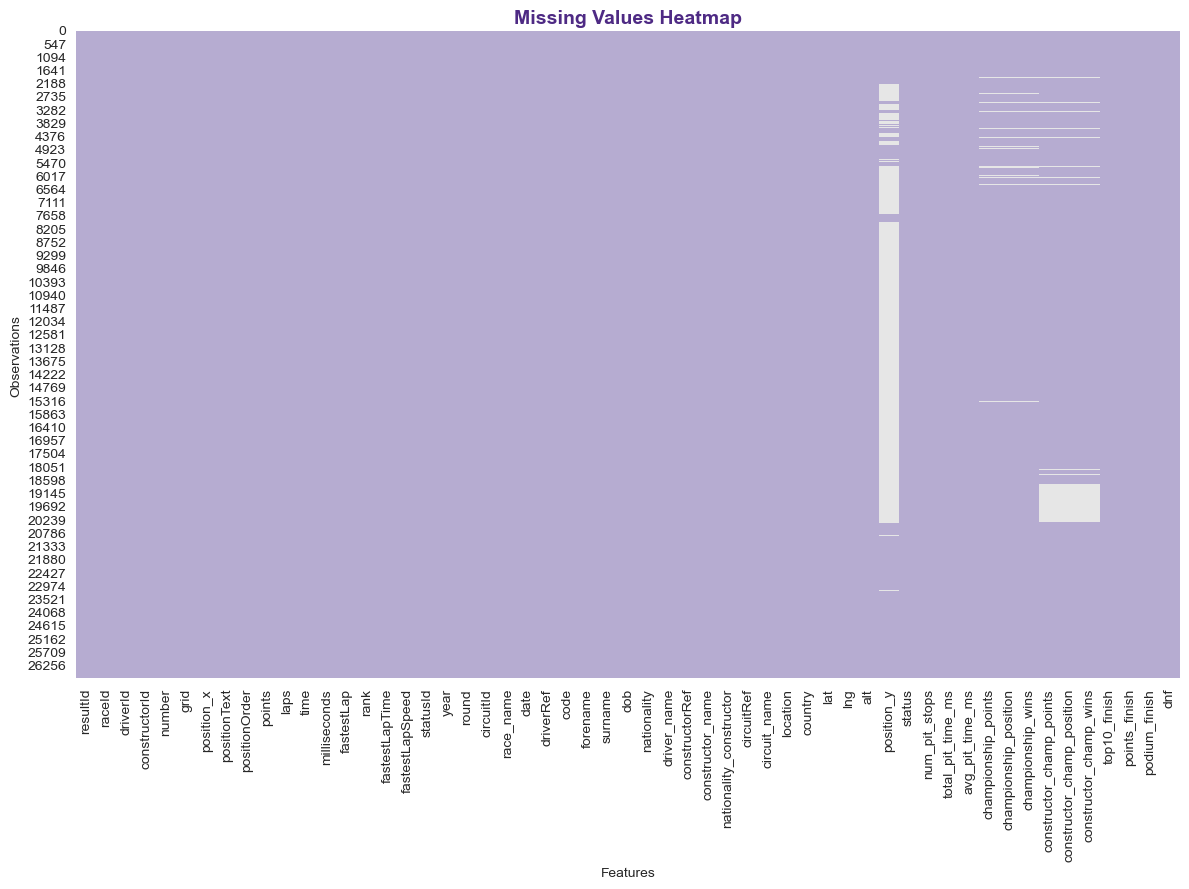

In [15]:
# Visualize missing values across the dataset
plt.figure(figsize=(12, 9))

sns.heatmap(
    df.isnull(),
    cbar=False,
    cmap=missing_cmap
)

plt.title("Missing Values Heatmap", fontweight="bold")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.tight_layout()
plt.show()

In [16]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = (
    pd.DataFrame({
        "Feature": missing.index,
        "Missing Count": missing.values,
        "Percentage (%)": missing_pct.values
    })
    .query("`Missing Count` > 0")
    .sort_values("Missing Count", ascending=False)
    .reset_index(drop=True)
)

nu_style_table(
    missing_df,
    caption="Variables with Missing Values"
)

,Feature,Missing Count,Percentage (%)
0,position_y,16275,60.820658
1,constructor_champ_points,1867,6.977092
2,constructor_champ_position,1867,6.977092
3,constructor_champ_wins,1867,6.977092
4,championship_points,469,1.752681
5,championship_position,469,1.752681
6,championship_wins,469,1.752681


Our missing values check shows that the integrated dataset is largely complete. Missingness is concentrated almost entirely in a single feature, qualifying_position. Approximately 60.8 percent of observations lack qualifying position data, which is consistent with historical coverage differences, as qualifying records are not available for many earlier seasons and some race entries. The missing values heatmap confirms this pattern visually, with missing values appearing as a prominent vertical band under the qualifying position column rather than being spread across many variables.

This finding is important for modeling because qualifying performance is likely a strong predictor of top-10 race outcomes. However, the high level of missingness means that qualifying position cannot be used directly across the full 1950–2024 timeframe without careful handling. In later data preparation, this issue will need to be addressed systematically, such as by limiting modeling to seasons with qualifying data, adding a qualifying-missing indicator, or using alternative starting position variables such as grid to ensure consistent feature availability and reduce bias.

## Target Variable Distribution and Context Over Time
This section presents exploratory visualizations that describe how top-10 finishes, DNFs, and related outcomes vary over time. These plots provide context for the target variable and help identify broad patterns in race outcomes before model development.

### Top-10 Finishes Over Time (Count and Rate)
The chart below shows both the total number of top-10 finishes per season and the proportion of race entries that resulted in a top-10 finish.


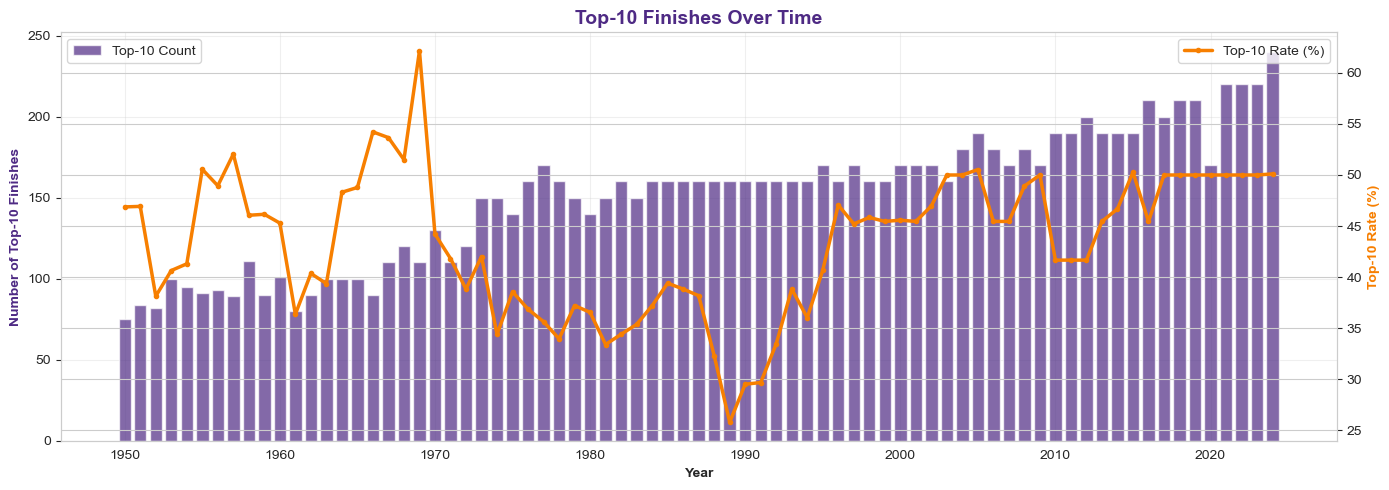

In [17]:
# Aggregate yearly top-10 statistics
yearly_top10 = (
    df.groupby('year')
      .agg(
          top10_count=('top10_finish', 'sum'),
          top10_rate=('top10_finish', 'mean'),
          num_races=('raceId', 'nunique')
      )
      .reset_index()
)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 5))

# Bar plot: total top-10 finishes
ax.bar(
    yearly_top10['year'],
    yearly_top10['top10_count'],
    color=NU_COLORS['purple'],
    alpha=0.7,
    label='Top-10 Count'
)

# Line plot: top-10 finish rate
ax2 = ax.twinx()
ax2.plot(
    yearly_top10['year'],
    yearly_top10['top10_rate'] * 100,
    color=NU_COLORS['accent_orange'],
    linewidth=2.5,
    marker='o',
    markersize=3,
    label='Top-10 Rate (%)'
)

# Formatting
ax.set_title(
    "Top-10 Finishes Over Time",
    fontsize=14,
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.set_xlabel("Year", fontweight='bold')
ax.set_ylabel("Number of Top-10 Finishes", fontweight='bold', color=NU_COLORS['purple'])
ax2.set_ylabel("Top-10 Rate (%)", fontweight='bold', color=NU_COLORS['accent_orange'])

ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

The top-10 trend shows two distinct dynamics: volume and baseline difficulty. The purple bars indicate that the number of top-10 finishes generally increases over time. This pattern is expected, as the sport expands with more races per season and more driver–race entries, which naturally leads to a higher absolute count of top-10 finishes.

In contrast, the orange line representing the top-10 finish rate varies substantially across eras before stabilizing in more recent seasons, where it remains roughly within the high-40 to 50 percent range. The larger fluctuations observed in earlier decades likely reflect structural differences in Formula One over time, including changes in grid size, race formats, and vehicle reliability. As a result, the same “top-10” label does not represent an identical competitive baseline across all seasons.

This temporal drift suggests that modeling should account for era effects. Including season or year-related features, or using time-based train–test splits, may help ensure that predictive models learn patterns that generalize well to modern racing conditions rather than overfitting to historical contexts.

### Top-10 Rate by Starting Grid Position
This visualization examines the relationship between a driver’s starting grid position and the likelihood of finishing in the top 10. It provides insight into how starting position influences race outcomes and helps assess the importance of qualifying performance.

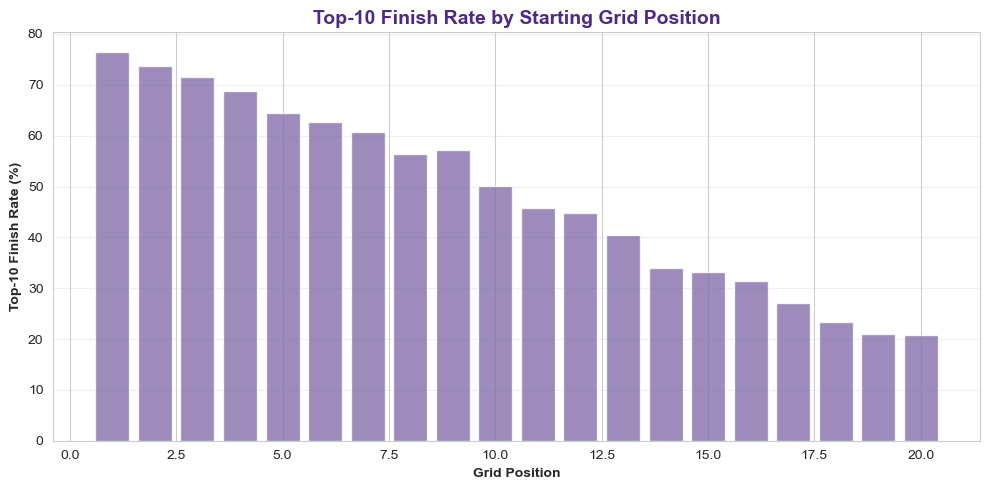

In [18]:
# Calculate top-10 finish rate by starting grid position
grid_top10 = df.groupby('grid')['top10_finish'].mean() * 100

# Limit to the first 20 grid positions for clarity
grid_positions = list(range(1, min(21, len(grid_top10) + 1)))
grid_rates = grid_top10.loc[grid_positions]

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(
    grid_positions,
    grid_rates,
    color=NU_COLORS['light_purple'],
    alpha=0.8
)

ax.set_title(
    "Top-10 Finish Rate by Starting Grid Position",
    fontsize=14,
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.set_xlabel("Grid Position", fontweight='bold')
ax.set_ylabel("Top-10 Finish Rate (%)", fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

The top-10 finish rate by starting grid position shows a clear and nearly monotonic decline as grid position moves backward. Drivers starting on the front row have a top-10 probability above 70 percent, while those starting in the middle of the grid, around positions 10 to 12, have a top-10 probability of approximately 45 to 50 percent. Drivers starting near the back of the grid, in positions 18 to 20, have a much lower top-10 probability of roughly 20 percent. This strong gradient highlights starting position as one of the most influential determinants of race outcome and reflects both underlying car performance and the tactical advantage of track position.

From a modeling perspective, this result confirms that grid position and qualifying-related features have substantial predictive power. At the same time, the pattern suggests diminishing marginal gains at the very front of the grid and a steep performance penalty for poor starting positions. These non-linear effects indicate that more flexible models may capture this relationship more effectively than simple linear approaches.

### Correlation Between Outcome Indicators
This visualization examines the relationships between the primary target variable and related race outcome indicators. Understanding how these outcomes are correlated helps clarify whether they capture distinct aspects of race performance or overlapping information.

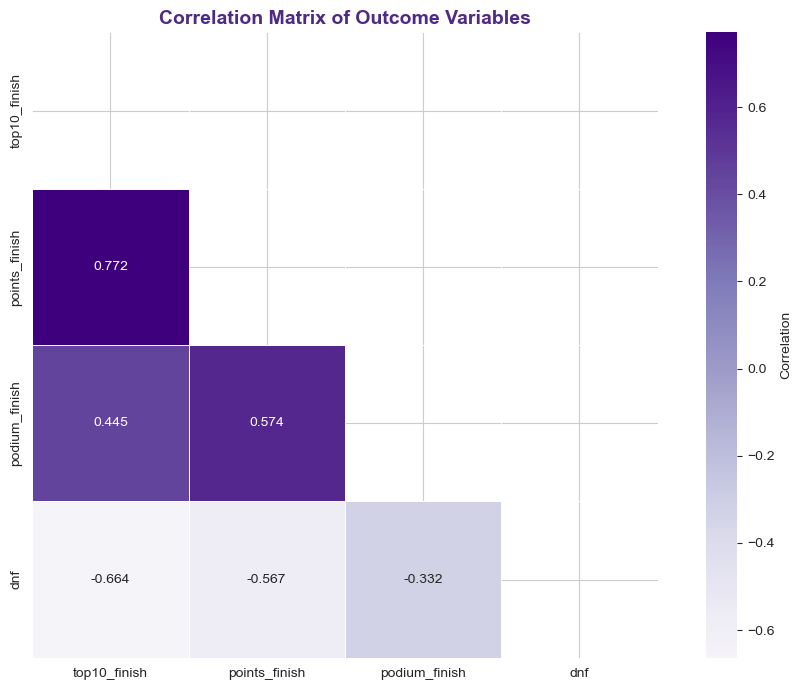

In [19]:
# Correlation matrix for outcome variables
corr_matrix = df[['top10_finish', 'points_finish', 'podium_finish', 'dnf']].corr()

fig, ax = plt.subplots(figsize=(10, 7))

# Mask upper triangle for cleaner visualization
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.3f',
    cmap='Purples',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'},
    ax=ax
)

ax.set_title(
    'Correlation Matrix of Outcome Variables',
    fontsize=14,
    fontweight='bold',
    color=NU_COLORS['purple']
)

plt.tight_layout()
plt.show()

The correlation matrix shows strong and expected relationships among the outcome indicators while confirming that each captures a different aspect of race performance. Top-10 finishes and points finishes are highly correlated (ρ ≈ 0.77), reflecting the points-scoring structure of modern Formula One. Podium finishes have a moderate correlation with Top-10 results (ρ ≈ 0.45) and a stronger relationship with points finishes (ρ ≈ 0.57), indicating that podiums represent a more selective form of success. In contrast, DNF status is negatively correlated with all positive outcomes, most strongly with Top-10 finishes (ρ ≈ −0.66), highlighting the importance of reliability and race completion. Overall, these relationships support using Top-10 finish as the primary target variable while retaining other outcomes for complementary analysis and validation.


### DNF Rate Over Time
This plot shows a steady decline in DNF rates over time, reflecting major improvements in car reliability, safety, and race engineering across Formula One eras.

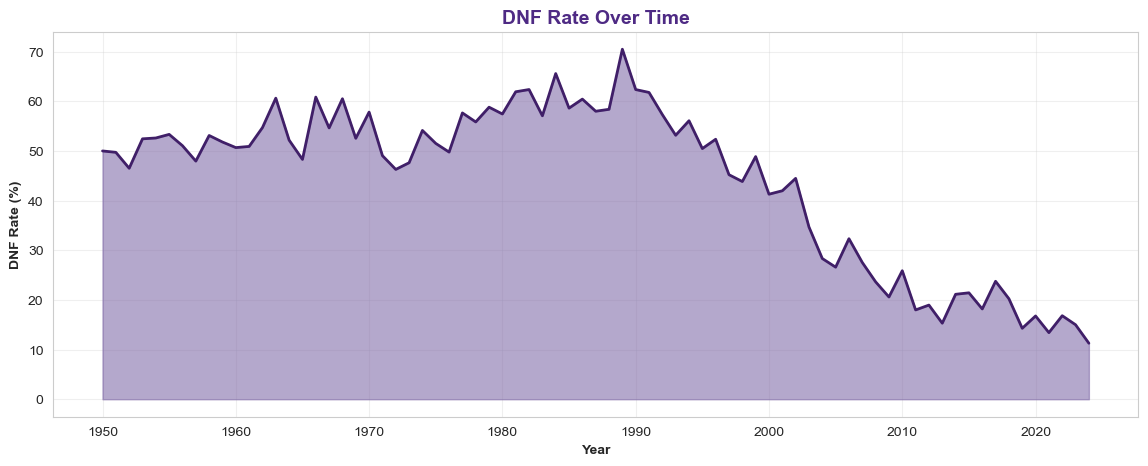

In [20]:
yearly_dnf = df.groupby('year')['dnf'].mean() * 100

fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(yearly_dnf.index, yearly_dnf.values,
                color=NU_COLORS['light_purple'], alpha=0.6)
ax.plot(yearly_dnf.index, yearly_dnf.values,
        color=NU_COLORS['dark_purple'], linewidth=2)

ax.set_title("DNF Rate Over Time", fontsize=14, fontweight='bold', color=NU_COLORS['purple'])
ax.set_xlabel("Year", fontweight='bold')
ax.set_ylabel("DNF Rate (%)", fontweight='bold')
ax.grid(True, alpha=0.3)

plt.show()

The DNF (Did Not Finish) rate visualization shows a clear long-term decline, reflecting major improvements in vehicle reliability, safety standards, and race management throughout the history of Formula One. From the 1950s through the late 1980s, DNF rates frequently exceeded 50–60%, indicating that mechanical failures and accidents were common and often decisive factors in race outcomes. Beginning in the 1990s, the trend shifts sharply downward, with DNF rates steadily decreasing to below 20% in recent seasons. This structural change has important modeling implications. In earlier eras, simply finishing a race was itself a significant achievement, whereas in modern Formula One, most drivers complete the race and finishing position becomes the primary differentiator of performance. As a result, predictive models should account for temporal effects, since the relative importance of reliability versus competitive performance has changed substantially over time.

### Distribution of Laps Completed (Finished Races Only)
This histogram shows how many laps drivers completed in races where they officially finished, which helps describe race distance patterns across events.

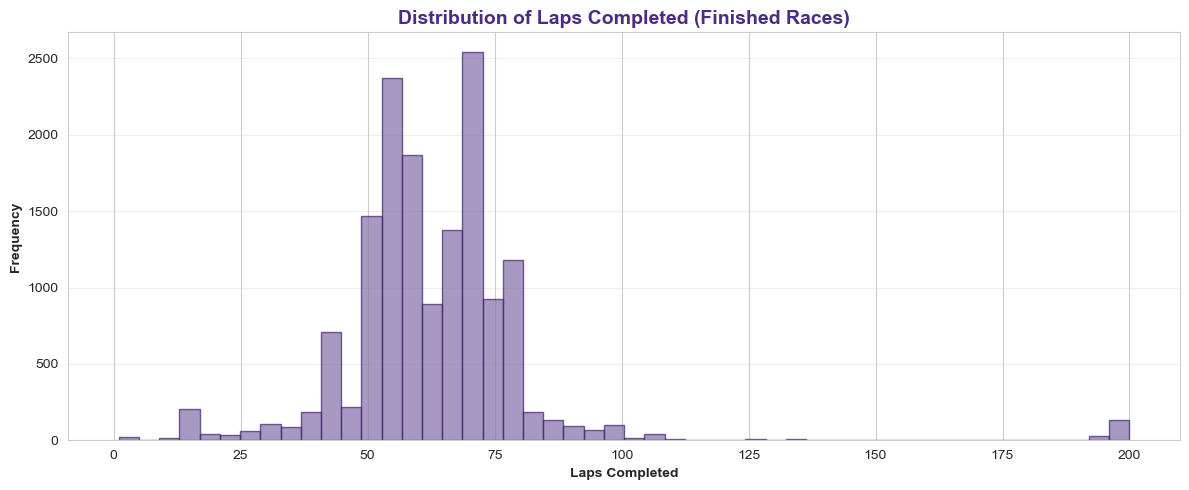

In [21]:
df_finished = df[df['dnf'] == 0]

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df_finished['laps'].dropna(), bins=50,
        color=NU_COLORS['light_purple'], alpha=0.7,
        edgecolor=NU_COLORS['dark_purple'])

ax.set_title("Distribution of Laps Completed (Finished Races)", fontsize=14, fontweight='bold', color=NU_COLORS['purple'])
ax.set_xlabel("Laps Completed", fontweight='bold')
ax.set_ylabel("Frequency", fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

The distribution of laps completed for finished races shows clear variation across the dataset. This variation is driven by differences in circuit length, race format, and historical race regulations. Most completed races cluster between roughly 50 and 80 laps, which aligns with standard race distances in modern Formula One and much of the late twentieth century. The long right tail reflects earlier seasons where shorter lap lengths required a much higher number of laps to complete a race. In addition, the presence of a small number of very low and very high lap counts highlights the heterogeneity of race structures across different eras. This variability reinforces the importance of contextual features such as circuit characteristics and season when modeling race outcomes. It also suggests that raw lap counts should be interpreted carefully or normalized if they are used in downstream feature engineering.

## Top Performers Analysis
This section examines historical top performers in Formula One, including drivers, constructors, and circuits. The visualizations focus on both the frequency and rate of top-10 finishes, as well as circuits that host the most races, to highlight persistent performance patterns and structural advantages within the sport.

### Top Drivers by Number of Top-10 Finishes
This visualization shows the drivers with the highest number of top-10 finishes across all races in the dataset. To ensure fair comparison, only drivers with at least 50 race entries are included.

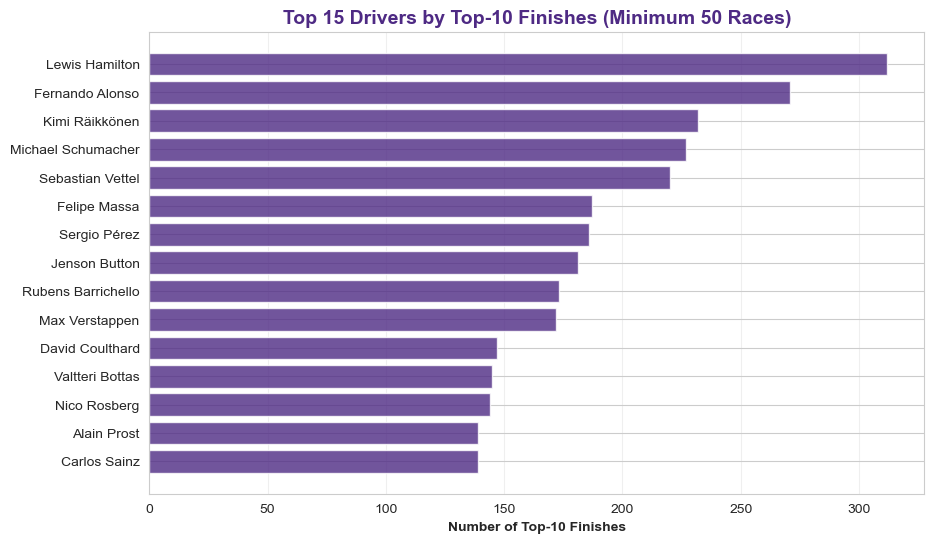

In [22]:
# Top 15 drivers by number of Top-10 finishes
top_drivers = (
    df.groupby('driver_name')['top10_finish']
      .agg(['sum', 'count'])
      .reset_index()
)

top_drivers = top_drivers[top_drivers['count'] >= 50].nlargest(15, 'sum')

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    range(len(top_drivers)),
    top_drivers['sum'],
    color=NU_COLORS['purple'],
    alpha=0.8
)

ax.set_yticks(range(len(top_drivers)))
ax.set_yticklabels(top_drivers['driver_name'])
ax.invert_yaxis()
ax.set_xlabel('Number of Top-10 Finishes', fontweight='bold')
ax.set_title(
    'Top 15 Drivers by Top-10 Finishes (Minimum 50 Races)',
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.grid(True, alpha=0.3, axis='x')

plt.show()

The top-driver ranking by total Top-10 finishes illustrates how sustained participation and long-term competitiveness shape cumulative success in Formula One. With a minimum threshold of 50 races, the leaderboard is dominated by drivers with multi-season careers and extended periods competing for strong constructors. This supports the idea that Top-10 outcomes reflect a combination of individual driver skill and constructor quality over time. Importantly, this chart measures volume (total Top-10 counts), which is naturally influenced by era-level differences such as the number of races per season and overall career length. Modern drivers benefit from longer calendars with more races per season, giving them more opportunities to accumulate Top-10 finishes compared to earlier-era drivers who competed in much shorter seasons. As a result, this visualization provides valuable descriptive context about dominant performers while also motivating the complementary use of rate-based metrics, such as Top-10 finish rate, to enable fairer comparisons across different careers and historical periods.

### Top Constructors by Number of Top-10 Finishes
This visualization highlights constructors that consistently place drivers in the top 10 positions. Only constructors with at least 50 race participations are included.

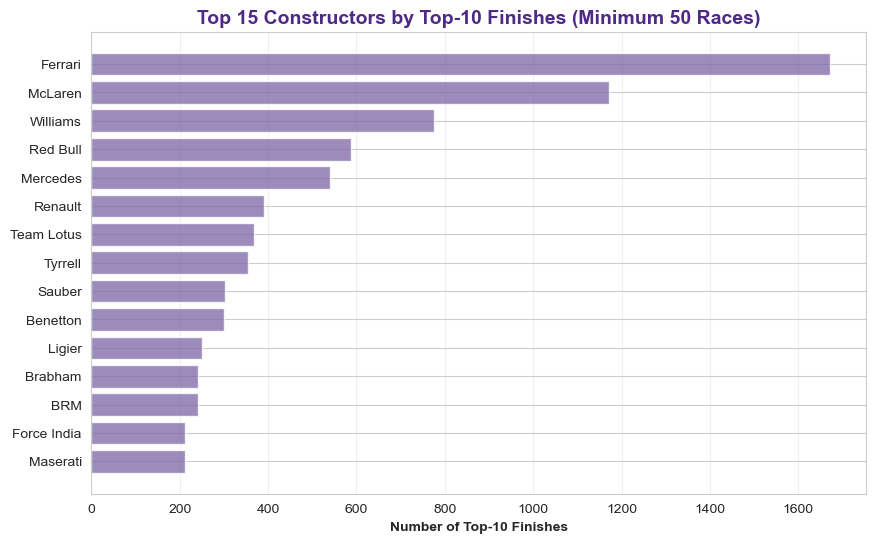

In [23]:
# Top 15 constructors by number of Top-10 finishes
top_constructors = (
    df.groupby('constructor_name')['top10_finish']
      .agg(['sum', 'count'])
      .reset_index()
)

top_constructors = top_constructors[top_constructors['count'] >= 50].nlargest(15, 'sum')

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    range(len(top_constructors)),
    top_constructors['sum'],
    color=NU_COLORS['light_purple'],
    alpha=0.8
)

ax.set_yticks(range(len(top_constructors)))
ax.set_yticklabels(top_constructors['constructor_name'])
ax.invert_yaxis()
ax.set_xlabel('Number of Top-10 Finishes', fontweight='bold')
ax.set_title(
    'Top 15 Constructors by Top-10 Finishes (Minimum 50 Races)',
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.grid(True, alpha=0.3, axis='x')

plt.show()

The constructor ranking by total Top-10 finishes highlights the strong and persistent role of team performance in shaping Formula One race outcomes. Teams such as Ferrari, McLaren, and Williams appear at the top largely because of their long tenure in the sport and sustained competitiveness across many seasons, which provides more cumulative opportunities to place drivers in the Top-10. At the same time, newer-era dominant teams such as Red Bull and Mercedes rank highly despite fewer historical seasons, reflecting periods of exceptional car performance and consistent points-scoring finishes. Similar to the driver ranking, this measure captures cumulative volume and is therefore influenced by participation history and the number of races per season. From a modeling perspective, these results reinforce that constructor identity is a critical explanatory factor and suggest that incorporating team-level features, such as historical Top-10 rates or recent constructor form, should improve predictive performance beyond driver-only information.

### Top Drivers by Top-10 Finish Rate
This figure ranks drivers by their top-10 finish rate rather than total count. A minimum of 100 races is required to focus on drivers with sustained participation and performance.

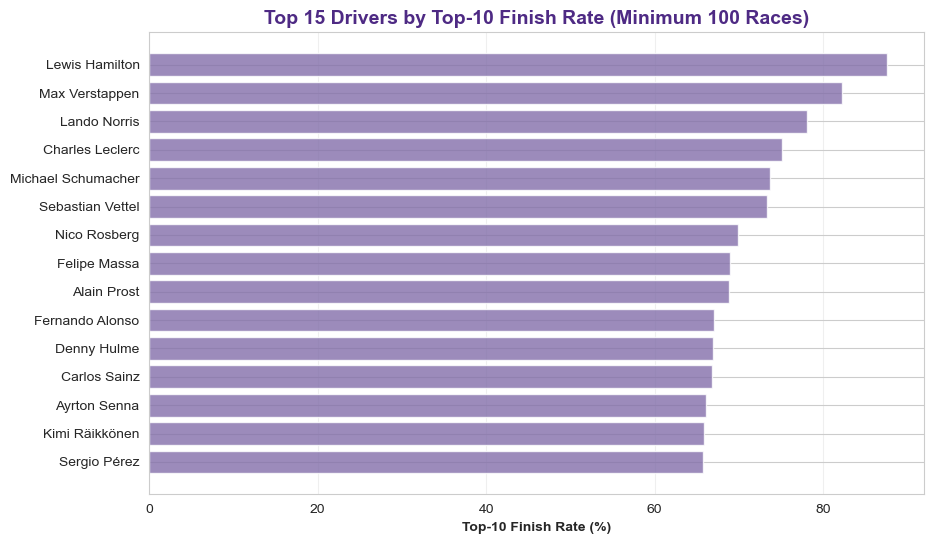

In [24]:
# Top 15 drivers by Top-10 finish rate
driver_rates = (
    df.groupby('driver_name')
      .agg(top10_rate=('top10_finish', 'mean'),
           race_count=('raceId', 'count'))
      .reset_index()
)

driver_rates = driver_rates[driver_rates['race_count'] >= 100].nlargest(15, 'top10_rate')
driver_rates['top10_rate'] *= 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    range(len(driver_rates)),
    driver_rates['top10_rate'],
    color=NU_COLORS['light_purple'],
    alpha=0.8
)

ax.set_yticks(range(len(driver_rates)))
ax.set_yticklabels(driver_rates['driver_name'])
ax.invert_yaxis()
ax.set_xlabel('Top-10 Finish Rate (%)', fontweight='bold')
ax.set_title(
    'Top 15 Drivers by Top-10 Finish Rate (Minimum 100 Races)',
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.grid(True, alpha=0.3, axis='x')

plt.show()

Ranking drivers by Top-10 finish rate rather than total count provides a more normalized view of performance that accounts for differences in career length and era-specific race calendars, such as the higher number of races per season in modern Formula One. With a minimum of 100 race entries, the leading drivers show consistently high Top-10 probabilities, reflecting sustained competitiveness rather than accumulated volume. The presence of both modern-era drivers and historical legends indicates that elite performance is characterized by reliability and pace relative to contemporaries, even as the sport evolves. Compared with cumulative Top-10 counts, this rate-based perspective reduces bias from participation volume and highlights drivers who convert race entries into strong results more efficiently. From a modeling perspective, this supports the use of normalized, rate-based driver features—such as rolling Top-10 rates or recent performance averages—to better capture underlying driver quality and reduce distortion from historical participation differences.

### Circuits with the Highest Number of Races
This visualization shows the circuits that appear most frequently in the dataset. These circuits represent long-standing venues in Formula One history.

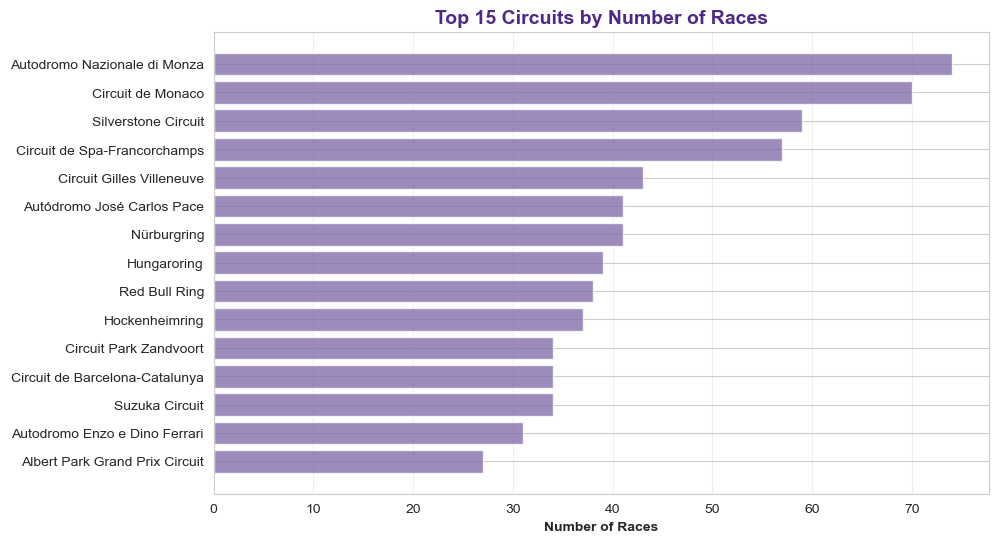

In [25]:
# Top 15 circuits by number of races
circuit_counts = (
    df.groupby('circuit_name')['raceId']
      .nunique()
      .nlargest(15)
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    range(len(circuit_counts)),
    circuit_counts.values,
    color=NU_COLORS['light_purple'],
    alpha=0.8
)

ax.set_yticks(range(len(circuit_counts)))
ax.set_yticklabels(circuit_counts.index)
ax.invert_yaxis()
ax.set_xlabel('Number of Races', fontweight='bold')
ax.set_title(
    'Top 15 Circuits by Number of Races',
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.grid(True, alpha=0.3, axis='x')

plt.show()

The distribution of races across circuits shows that a small group of tracks have served as long-term anchors of the Formula One calendar. Circuits such as Monza, Monaco, Silverstone, and Spa-Francorchamps appear most frequently, reflecting their historical significance and continued inclusion across multiple eras of Formula One racing. As a result, these high-frequency circuits contribute disproportionately to the dataset. They may also have persistent track-specific characteristics, such as layout, overtaking difficulty, or typical weather conditions, that systematically influence race outcomes. From a modeling standpoint, this uneven circuit distribution suggests that circuit effects should be explicitly accounted for, either through circuit-level features or historical performance summaries, to avoid predictions being overly driven by patterns from a small set of long-standing tracks.

# Feature Engineering
This section focuses on transforming the integrated Formula One dataset into a set of meaningful features that can be used for predictive modeling. The goal of feature engineering is to represent driver performance, constructor strength, race context, and temporal effects in a structured and informative way. Using historical race information, we derive features that capture prior performance trends, competitive context entering each race, and circuit-specific characteristics, while carefully avoiding data leakage by ensuring that only information available before each race is used. These engineered features provide a richer representation of race conditions and are designed to support accurate and interpretable prediction of Top-10 finishes in later modeling stages.

## Temporal Features
Temporal features capture the timing and stage of each race within a season. The driver_age feature is computed using the driver’s date of birth relative to the race date, which allows the model to account for career-stage effects such as experience or age-related performance changes. The season_stage variable divides the race calendar into early, mid, late, and end-of-season phases. This helps capture differences in competitive dynamics, including early-season uncertainty, mid-season development, and increased championship pressure toward the end of the season.

In [26]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

df['race_month'] = df['date'].dt.month
df['race_day_of_year'] = df['date'].dt.dayofyear
df['season_stage'] = pd.cut(df['round'], bins=[0, 7, 14, 21, 100],
                             labels=['early', 'mid', 'late', 'end'])

# Calculate driver age at race
df['driver_age'] = (df['date'] - pd.to_datetime(df['dob'])).dt.days / 365.25

## Performance History Features
Performance history features summarize recent and long-term driver performance using only information available before each race. A rolling window of the previous five races is used, with shift(1) applied to prevent data leakage from the current race. These rolling features capture short-term form, such as recent consistency or improvement, while career-level expanding averages provide a stable long-term performance baseline. This approach is supported by prior work showing that historical finishing patterns are informative predictors of future race outcomes. In particular, Patil et al. (2023) highlight the importance of recent performance trends, while Bansal (2025) demonstrates that lagged performance features contribute strongly to predictive accuracy in Formula One outcome models.

In [27]:
# Sort by driver and date for rolling calculations
df = df.sort_values(['driverId', 'date']).reset_index(drop=True)

# Driver historical performance (last 5 races)
df['driver_prev_5_top10_rate'] = df.groupby('driverId')['top10_finish'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
df['driver_prev_5_dnf_rate'] = df.groupby('driverId')['dnf'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
df['driver_prev_5_avg_position'] = df.groupby('driverId')['positionOrder'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Driver career statistics (up to current race)
df['driver_career_races'] = df.groupby('driverId').cumcount()
df['driver_career_top10_rate'] = df.groupby('driverId')['top10_finish'].transform(
    lambda x: x.shift(1).expanding().mean()
)
df['driver_career_points_per_race'] = df.groupby('driverId')['points'].transform(
    lambda x: x.shift(1).expanding().mean()
)

## Constructor Features
Constructor features capture team-level performance history using rolling and expanding statistics, analogous to the driver-level features. These features reflect the fact that Formula One race outcomes are strongly influenced by car performance, engineering quality, and team strategy. This approach is supported by van Kesteren and Bergkamp (2023), whose Bayesian analysis shows that a large share of performance variance in Formula One can be attributed to the constructor rather than the individual driver. Rolling statistics summarize recent team form, while season-level expanding averages capture within-season development and performance trends as teams introduce upgrades and adapt strategies over time.

In [28]:
# Constructor historical performance
df = df.sort_values(['constructorId', 'date']).reset_index(drop=True)

df['constructor_prev_5_top10_rate'] = df.groupby('constructorId')['top10_finish'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
df['constructor_prev_5_dnf_rate'] = df.groupby('constructorId')['dnf'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Constructor season performance
df['constructor_season_top10_rate'] = df.groupby(['constructorId', 'year'])['top10_finish'].transform(
    lambda x: x.shift(1).expanding().mean()
)

## Circuit Characteristics
Circuit features are derived using expanding historical averages with shift(1) applied to strictly prevent data leakage, ensuring that only information from prior races at a given venue is used. Circuit-level DNF rate is included as a proxy for track difficulty and reliability, while measures of finishing position volatility capture how unpredictable race outcomes tend to be at each circuit. High-altitude circuits, defined as those above 500 meters, are flagged using a binary indicator due to their potential impact on engine performance and race strategy. Prior research by Rockerbie and Easton (2022) highlights that circuit characteristics interact with both driver skill and constructor capability, reinforcing the importance of incorporating track-specific context into race outcome modeling.

In [29]:
# Maintain a single, stable ordering
df = df.sort_values(['date', 'raceId', 'driverId']).reset_index(drop=True)

# Circuit-level historical DNF rate
df['circuit_avg_dnf_rate'] = df.groupby('circuitId')['dnf'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(df['dnf'].mean())

# Circuit position volatility
df['circuit_position_volatility'] = df.groupby('circuitId')['positionOrder'].transform(
    lambda x: x.shift(1).expanding().std()
).fillna(df['positionOrder'].std())

# Circuit historical top-10 rate
df['circuit_avg_top10_rate'] = df.groupby('circuitId')['top10_finish'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(0.5)

# Driver–circuit history
df['driver_circuit_top10_rate'] = df.groupby(['driverId', 'circuitId'])['top10_finish'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(0.5)

# High-altitude circuit indicator
df['alt'] = pd.to_numeric(df['alt'], errors='coerce')
df['high_altitude_circuit'] = (df['alt'] > 500).astype(int)

## Driver-Constructor Interaction
Driver–constructor interaction features are designed to capture the synergy between a specific driver and their team. Prior work by Gu et al. (2021) shows that modeling cooperation effects between participants can significantly improve outcome prediction. In the context of Formula One, a driver’s familiarity with a team’s car, engineering philosophy, and race operations can strongly influence performance. Features such as the number of races completed together (driver_constructor_races) and joint historical success rates are therefore used to represent this interaction and provide additional context beyond driver-only or constructor-only features.

In [30]:
# Keep a stable ordering
df = df.sort_values(['date', 'raceId', 'driverId']).reset_index(drop=True)

# Driver experience with constructor (counts prior races together)
df['driver_constructor_races'] = df.groupby(['driverId', 'constructorId']).cumcount()

# Driver–constructor historical top-10 rate (leakage-safe)
df['driver_constructor_top10_rate'] = df.groupby(['driverId', 'constructorId'])['top10_finish'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(0.5)

## Qualifying-Based Features
Qualifying performance, represented by starting grid position, is widely regarded as one of the strongest predictors of race outcomes in Formula One. Prior work by Bansal (2025) shows that grid position contributes a large share of predictive power when forecasting championship points. To capture this effect more flexibly, binary indicators for front-row starts, top-five, and top-ten grid positions are used. These features allow the model to represent non-linear threshold effects, where small differences in starting position can lead to meaningful changes in the likelihood of finishing in the top 10.

In [31]:
# Grid position features
df['grid_position_numeric'] = pd.to_numeric(df['grid'], errors='coerce')
df['front_row_start'] = (df['grid_position_numeric'] <= 2).astype(int)
df['top5_start'] = (df['grid_position_numeric'] <= 5).astype(int)
df['top10_start'] = (df['grid_position_numeric'] <= 10).astype(int)

# Grid position improvement potential
df['max_position_gain'] = df['grid_position_numeric'].fillna(0) - 1

## Competitive Context Features
Competitive context features normalize a driver’s grid position relative to the field size, accounting for the fact that field sizes have varied from approximately 20 to more than 30 cars across different Formula One eras. The grid_percentile feature provides a scale-invariant measure of starting competitiveness, which is especially important when training on data spanning 1950–2024. Prior work has shown that incorporating contextual factors improves prediction accuracy in sports analytics (Zheng 2022).


In [32]:
# Number of competitors per race
df['num_competitors'] = df.groupby('raceId')['driverId'].transform('count')

# Driver's relative grid position (percentile)
df['grid_percentile'] = df.groupby('raceId')['grid_position_numeric'].rank(pct=True)

## Momentum and Streak Features
Momentum features capture the psychological and performance dynamics associated with winning streaks and cold spells. The consecutive Top-10 streak reflects the intensity of a driver’s current form, while the three-race points sum provides a weighted measure of recent performance. The position trend feature, defined as the difference between the three-race and five-race average finishing positions, indicates whether a driver’s performance is improving or declining over time. This is particularly useful for identifying mid-season car upgrades or periods of driver adaptation. Jafri (2024) showed that incorporating temporal momentum signals significantly improved predictive accuracy in sequential race outcome models.


In [33]:
# Keep stable ordering for all feature engineering
df = df.sort_values(['date', 'raceId', 'driverId']).reset_index(drop=True)

# Momentum: consecutive top-10 finishes streak (leakage-safe)
shifted_top10 = df.groupby('driverId')['top10_finish'].shift(1).fillna(0).astype(int)

# Streak = count consecutive 1s since last 0, within each driver
streak_group = shifted_top10.eq(0).groupby(df['driverId']).cumsum()
df['driver_top10_streak'] = shifted_top10.groupby([df['driverId'], streak_group]).cumsum()

# Points momentum: points scored in last 3 races (leakage-safe)
df['driver_points_last3'] = df.groupby('driverId')['points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)

# Position improvement trend: 3-race avg minus 5-race avg (leakage-safe)
avg3 = df.groupby('driverId')['positionOrder'].transform(
    lambda x: x.shift(1).rolling(3, min_periods=1).mean()
)
avg5 = df.groupby('driverId')['positionOrder'].transform(
    lambda x: x.shift(1).rolling(5, min_periods=1).mean()
)
df['driver_position_trend'] = (avg3 - avg5).fillna(0)

print("Momentum features created: driver_top10_streak, driver_points_last3, driver_position_trend")

Momentum features created: driver_top10_streak, driver_points_last3, driver_position_trend


## Pit Stop Strategy Features
Pit stop strategy features are used to capture operational efficiency, which is an important factor in modern Formula One racing. Previous research by Patil et al. (2023) shows that the number of pit stops and the timing of those stops can strongly affect race results and championship points. In this project, the constructor’s average pit stop time is used as a proxy for pit crew efficiency. A driver’s historical pit stop patterns are also included to reflect typical race strategies, such as whether a driver tends to follow a more aggressive or more conservative approach. These features help explain race outcomes beyond driver skill alone by accounting for team operations and strategy.

In [34]:
# Pit stop features from the merged pit_stops data
# Historical average pit stops per race for the driver
df = df.sort_values(['driverId', 'date']).reset_index(drop=True)

df['driver_avg_pit_stops'] = df.groupby('driverId')['num_pit_stops'].transform(
    lambda x: x.shift(1).expanding().mean()
)
df['driver_avg_pit_stops'] = df['driver_avg_pit_stops'].fillna(df['num_pit_stops'].median())

# Constructor average pit time (proxy for pit crew efficiency)
df = df.sort_values(['constructorId', 'date']).reset_index(drop=True)
df['constructor_avg_pit_time'] = df.groupby('constructorId')['avg_pit_time_ms'].transform(
    lambda x: x.shift(1).expanding().mean()
)
df['constructor_avg_pit_time'] = df['constructor_avg_pit_time'].fillna(df['avg_pit_time_ms'].median())

print('Pit stop features created: driver_avg_pit_stops, constructor_avg_pit_time')


Pit stop features created: driver_avg_pit_stops, constructor_avg_pit_time


## Championship Context Features
Championship context features capture the broader competitive situation within a season. A driver who is close to the top of the championship standings may face different incentives and pressures than a driver with no realistic title contention. For example, drivers ranked near the top may take greater risks, benefit from team strategy decisions, or prioritize points accumulation over conservative driving. The gap in points to the championship leader reflects this competitive pressure and helps represent how season context may influence race outcomes. Prior work by Zheng (2022) shows that including external contextual factors alongside performance metrics improves prediction accuracy in sports analytics, which supports the inclusion of championship context features in this Formula One prediction task.

In [35]:
# Championship position and points entering the race
# These come from the driver_standings merge
# Fill missing championship data (early races of a season, or historical gaps)
df['championship_points'] = pd.to_numeric(df['championship_points'], errors='coerce').fillna(0)
df['championship_position'] = pd.to_numeric(df['championship_position'], errors='coerce').fillna(20)
df['championship_wins'] = pd.to_numeric(df['championship_wins'], errors='coerce').fillna(0)
df['constructor_champ_points'] = pd.to_numeric(df['constructor_champ_points'], errors='coerce').fillna(0)
df['constructor_champ_position'] = pd.to_numeric(df['constructor_champ_position'], errors='coerce').fillna(10)

# Is driver in championship contention? (top 5 in standings)
df['in_championship_contention'] = (df['championship_position'] <= 5).astype(int)

# Points gap to championship leader within each race
df['points_gap_to_leader'] = df.groupby('raceId')['championship_points'].transform(
    lambda x: x.max() - x
)

print('Championship context features created')


Championship context features created


## Era-Based Features
Formula One has experienced major regulation changes over time, which have affected car performance, reliability, and competition structure. These changes mean that race outcomes are not directly comparable across all seasons. Prior research, including van Kesteren and Bergkamp (2023), shows that performance patterns differ significantly across regulation eras, particularly during the hybrid era (2014–2021). By encoding the regulation era as a feature, this project allows the model to account for structural differences between periods of Formula One history and learn era-specific performance patterns rather than treating all seasons as equivalent.

In [36]:
# F1 has undergone major regulation changes that fundamentally alter performance dynamics
def assign_era(year):
    if year < 1966:
        return '1.5L_era'
    elif year < 1977:
        return '3L_era'
    elif year < 1989:
        return 'turbo_era'
    elif year < 1995:
        return 'v10_early'
    elif year < 2006:
        return 'v10_late'
    elif year < 2014:
        return 'v8_era'
    elif year < 2022:
        return 'hybrid_v6'
    else:
        return 'ground_effect'

df['era'] = df['year'].apply(assign_era)

# Encode era
era_le = LabelEncoder()
df['era_encoded'] = era_le.fit_transform(df['era'])

print('Eras assigned:', df['era'].value_counts().sort_index().to_dict())


Eras assigned: {'1.5L_era': 3339, '3L_era': 3237, 'ground_effect': 1359, 'hybrid_v6': 3267, 'turbo_era': 5234, 'v10_early': 3035, 'v10_late': 4000, 'v8_era': 3288}


## Categorical Encodings
The feature engineering pipeline above created more than 35 features across multiple feature groups. All rolling and expanding window calculations use shift(1) to ensure that the model only has access to information that would have been available before the race takes place. This design choice is critical for preventing data leakage and for ensuring that model evaluation reflects realistic prediction conditions. The following section focuses on encoding categorical variables and handling any remaining missing values before moving on to correlation analysis and baseline modeling.

In [37]:
label_encoders = {}

categorical_features = [
    'driverRef',
    'constructorRef',
    'circuitRef',
    'nationality',               # driver nationality
    'nationality_constructor',   # constructor nationality
    'country',                   # circuit country
    'era'                         # regulation era
]

# Apply label encoding to categorical features
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna('Unknown')
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le

# One-hot encode season stage
# Keep all categories to allow comparison across early/mid/late season
if 'season_stage' in df.columns:
    df['season_stage'] = df['season_stage'].astype(str).fillna('Unknown')
    df = pd.get_dummies(
        df,
        columns=['season_stage'],
        prefix='season',
        drop_first=False
    )

print("Label encoded columns:", categorical_features)
print("One-hot encoded column: season_stage")

Label encoded columns: ['driverRef', 'constructorRef', 'circuitRef', 'nationality', 'nationality_constructor', 'country', 'era']
One-hot encoded column: season_stage


# Missing Data Handling
The dataset contains some missing values, mainly because certain information was not available in earlier Formula One seasons. Most missing values appear in qualifying-related features and championship standings, especially in older races where these records were not consistently collected. Instead of dropping these rows, which would reduce the size and historical coverage of the dataset, missing values were handled in a practical way. Numerical features based on historical averages were filled using reasonable baseline values such as group medians or expanding means. Championship-related variables were filled with neutral values at the start of a season to reflect that no points or positions had been accumulated yet. Categorical variables with missing values were labeled as “Unknown” before encoding. This approach keeps the full dataset intact while allowing the features to be used safely in later analysis.

## Create missingness indicators
A binary indicator is created to flag missing qualifying position values. The qualifying_missing feature allows the model to capture whether the absence of qualifying data itself carries useful information, especially since qualifying records are unavailable for many early seasons. This helps retain historical races without discarding important contextual signals.

In [38]:
if "qualifying_position" in df.columns:
    df["qualifying_missing"] = df["qualifying_position"].isna().astype(int)

## Impute qualifying_position using grid as fallback
Because qualifying position is missing for many historical races, it is imputed using starting grid position when available. Grid position is consistently recorded across seasons and closely reflects qualifying performance. Any remaining missing values after this step are filled using the overall median. This approach preserves historical coverage while maintaining a realistic approximation of pre-race performance.

In [39]:
# rationale: grid is always available; qualifying often missing historically
if "qualifying_position" in df.columns:
    # coerce to numeric
    df["qualifying_position"] = pd.to_numeric(df["qualifying_position"], errors="coerce")
    df["grid_position_numeric"] = pd.to_numeric(df["grid_position_numeric"], errors="coerce")

    # Fill qualifying_position first with grid_position_numeric
    df["qualifying_position"] = df["qualifying_position"].fillna(df["grid_position_numeric"])

    # Remaining NA -> overall median (should be rare after grid fill)
    df["qualifying_position"] = df["qualifying_position"].fillna(df["qualifying_position"].median())

## Impute any remaining numeric missing values
Any remaining missing values in numeric features are filled using the median of each variable. Identifier fields and target variables are excluded from this step. Median imputation is used because it is robust to outliers and preserves the overall distribution of the data without introducing strong assumptions.

In [40]:
# Use median for numeric cols except IDs and target/outcomes
target_cols = ["top10_finish", "points_finish", "podium_finish", "dnf"]
id_cols = ["raceId", "driverId", "constructorId", "circuitId", "statusId"]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in target_cols + id_cols]

for col in numeric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

## Verification of Remaining Missing Values
A final check is performed to confirm that missing values have been handled properly. This step verifies that no major features still contain missing data before proceeding to correlation analysis and model development.

In [41]:
# Quick verification of remaining missing values
missing_after = (
    df.isnull()
      .sum()
      .reset_index()
      .rename(columns={'index': 'Feature', 0: 'Missing Count'})
)

missing_after = missing_after[missing_after['Missing Count'] > 0] \
    .sort_values('Missing Count', ascending=False) \
    .reset_index(drop=True)

if missing_after.empty:
    display(
        nu_style_table(
            pd.DataFrame(
                {"Status": ["No remaining missing values detected"]}),
            caption="Missing Data Verification Result"
        )
    )
else:
    display(
        nu_style_table(
            missing_after,
            caption="Remaining Missing Values After Imputation"
        )
    )

,Status
0,No remaining missing values detected


### Heatmap of remaining missing values

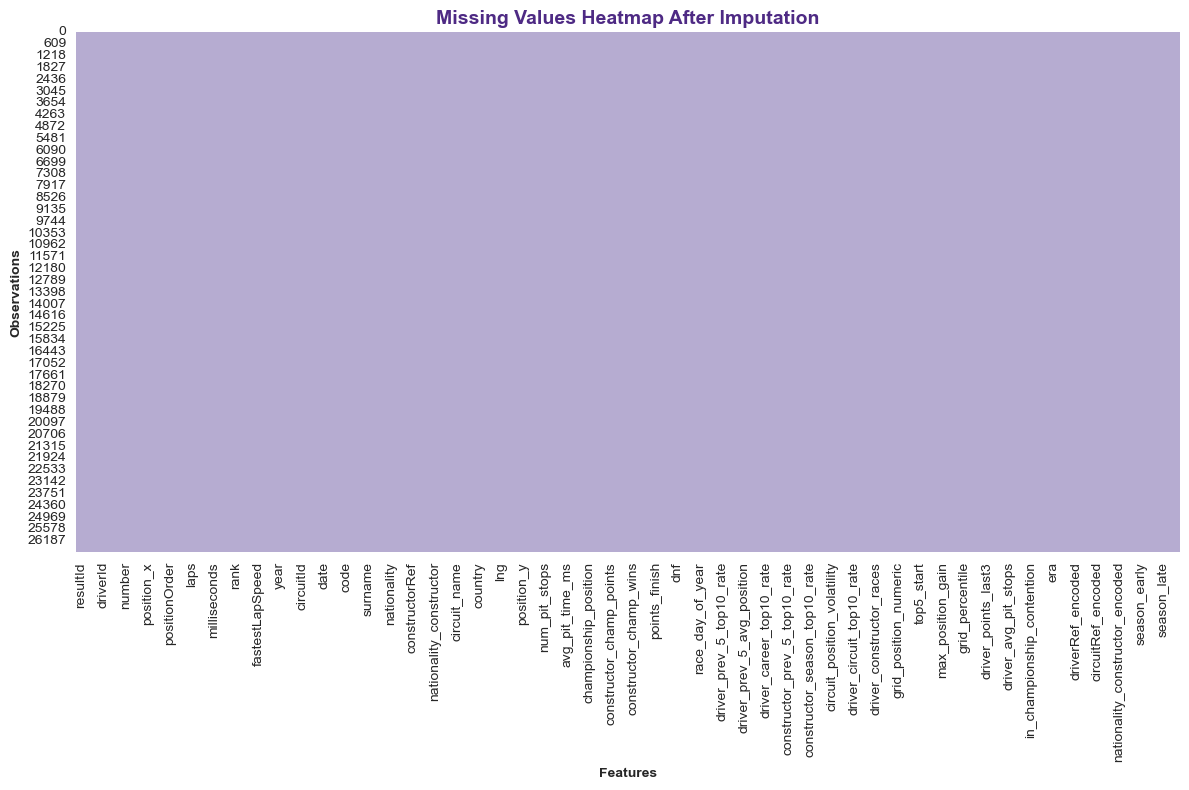

In [42]:
plt.figure(figsize=(12, 8))

sns.heatmap(
    df.isnull(),
    cbar=False,
    cmap=missing_cmap
)

plt.title(
    "Missing Values Heatmap After Imputation",
    fontsize=14,
    fontweight='bold',
    color=NU_COLORS['purple']
)
plt.xlabel("Features", fontweight='bold')
plt.ylabel("Observations", fontweight='bold')

plt.tight_layout()
plt.show()

# Final EDA After Feature Engineering
This section revisits the dataset after feature engineering and missing data handling to confirm data quality, inspect updated distributions, and ensure that the engineered features behave as expected. This final exploratory step validates that the dataset is ready for correlation analysis and baseline model development.

## Summary table
This table provides descriptive statistics for the engineered features and the target variable, offering a final validation of feature distributions and data readiness before model development.

In [43]:
# set of engineered features
engineered_features = [
    "driver_age",
    "driver_prev_5_top10_rate",
    "driver_prev_5_dnf_rate",
    "driver_prev_5_avg_position",
    "driver_career_races",
    "driver_career_top10_rate",
    "driver_career_points_per_race",
    "constructor_prev_5_top10_rate",
    "constructor_prev_5_dnf_rate",
    "constructor_season_top10_rate",
    "circuit_avg_dnf_rate",
    "circuit_position_volatility",
    "driver_circuit_top10_rate",
    "driver_constructor_races",
    "driver_constructor_top10_rate",
    "grid_position_numeric",
    "grid_percentile",
    "front_row_start",
    "top5_start",
    "top10_start",
    "max_position_gain",
    "num_competitors",
    "driver_top10_streak",
    "driver_points_last3",
    "driver_position_trend",
    "driver_avg_pit_stops",
    "constructor_avg_pit_time",
    "championship_points",
    "championship_position",
    "in_championship_contention",
    "points_gap_to_leader",
    "circuit_avg_top10_rate",
    "high_altitude_circuit",
]
engineered_features = [c for c in engineered_features if c in df.columns]

eda_summary = df[engineered_features + ["top10_finish"]].describe(include="all").T
eda_summary = eda_summary[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
nu_style_table(eda_summary.reset_index().rename(columns={"index": "feature"}).head(25),
              caption="Post-Feature-Engineering Summary (first 25 features)")


,feature,count,mean,std,min,25%,50%,75%,max
0,driver_age,26759.000000,29.992963,5.268514,17.453799,26.143737,29.429158,33.292266,58.787132
1,driver_prev_5_top10_rate,26759.000000,0.429239,0.312999,0.000000,0.200000,0.400000,0.600000,1.000000
2,driver_prev_5_dnf_rate,26759.000000,0.427354,0.300248,0.000000,0.200000,0.400000,0.600000,1.000000
3,driver_prev_5_avg_position,26759.000000,12.634121,5.429253,1.000000,9.000000,12.400000,15.600000,39.000000
4,driver_career_races,26759.000000,65.909414,68.167355,0.000000,14.000000,43.000000,96.000000,403.000000
5,driver_career_top10_rate,26759.000000,0.410518,0.226861,0.000000,0.250000,0.440000,0.571429,1.000000
6,driver_career_points_per_race,26759.000000,1.606848,2.297906,0.000000,0.153846,0.792453,2.088608,18.000000
7,constructor_prev_5_top10_rate,26759.000000,0.425165,0.306570,0.000000,0.200000,0.400000,0.600000,1.000000
8,constructor_prev_5_dnf_rate,26759.000000,0.431431,0.298463,0.000000,0.200000,0.400000,0.600000,1.000000
9,constructor_season_top10_rate,26759.000000,0.433244,0.279139,0.000000,0.222222,0.428571,0.631579,1.000000


## Distribution plots for key engineered features

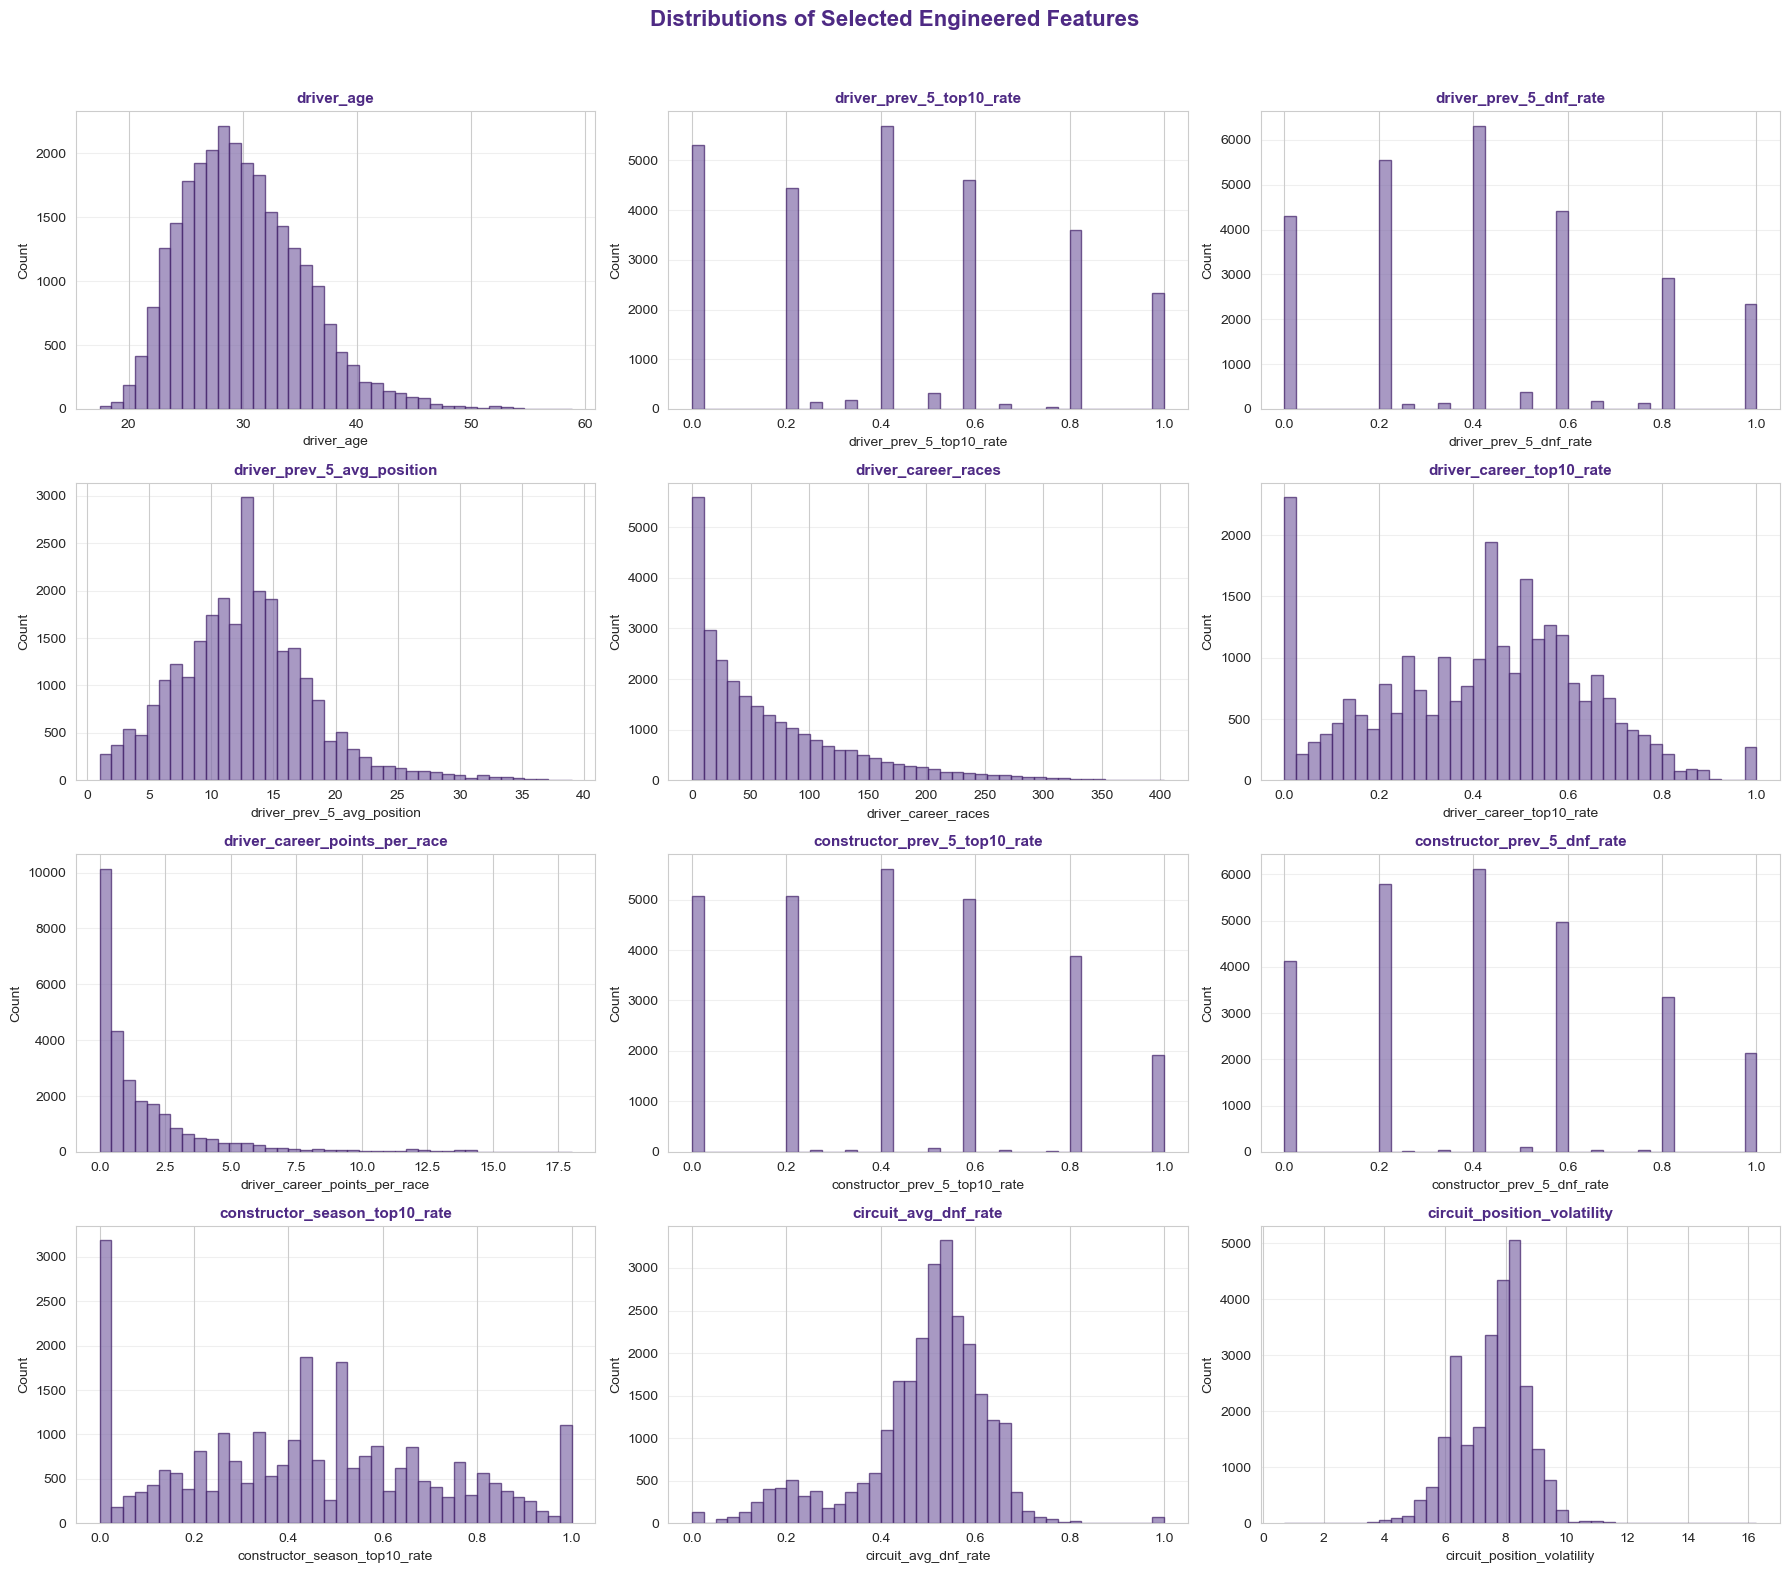

In [44]:
features_to_plot = engineered_features[:12]
n_cols = 3
n_rows = int(np.ceil(len(features_to_plot) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    axes[i].hist(
        df[col].dropna(),
        bins=40,
        color=NU_COLORS['light_purple'],
        edgecolor=NU_COLORS['dark_purple'],
        alpha=0.7
    )
    axes[i].set_title(col, fontsize=11, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].grid(True, alpha=0.3, axis='y')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(
    "Distributions of Selected Engineered Features",
    fontsize=16,
    fontweight='bold',
    color=NU_COLORS['purple']
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Temporal Drift Check for Key Engineered Features

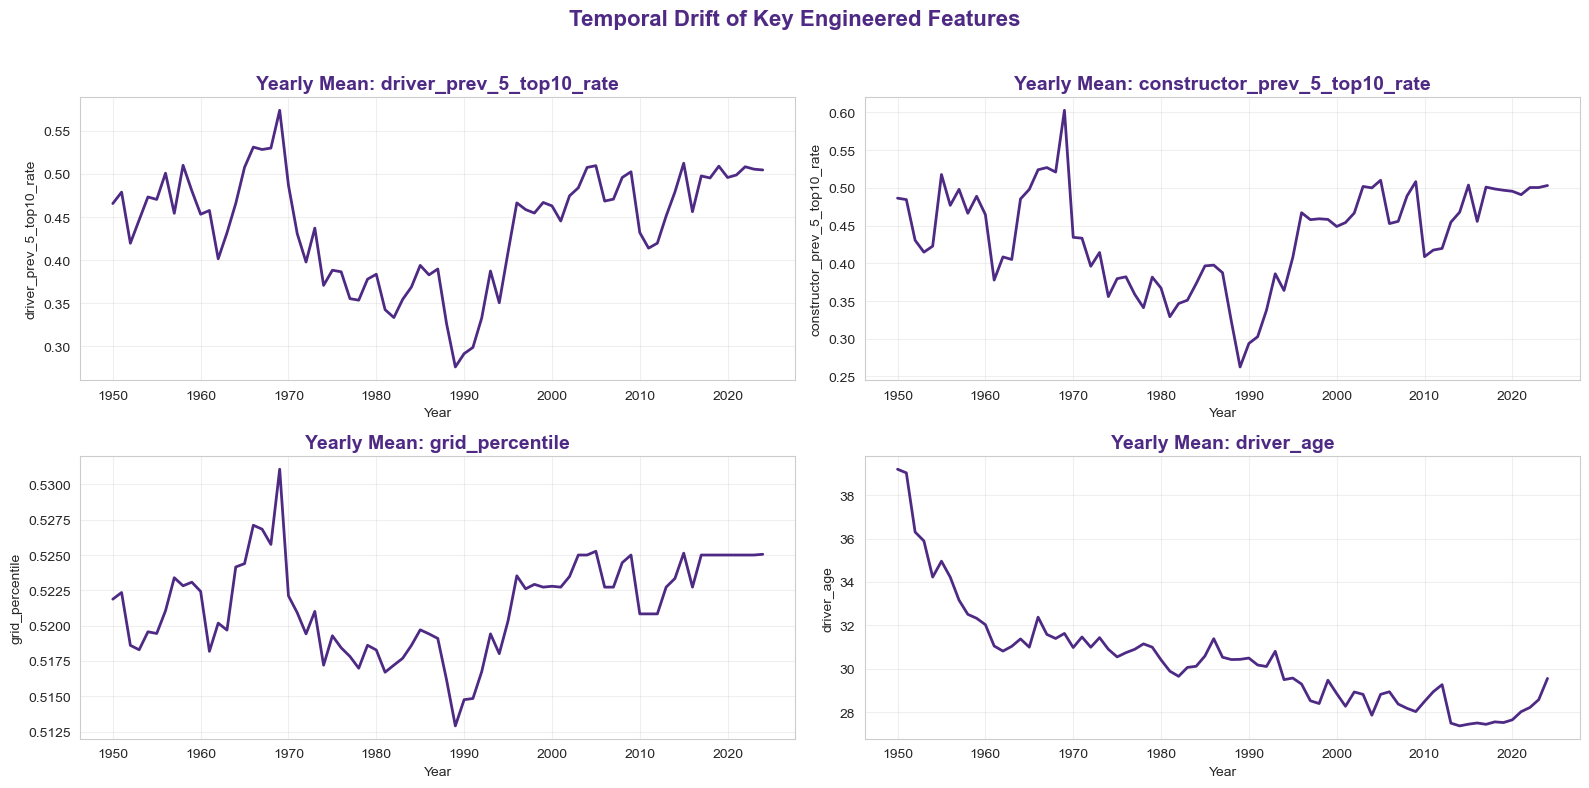

In [45]:
key_drift = [
    "driver_prev_5_top10_rate",
    "constructor_prev_5_top10_rate",
    "grid_percentile",
    "driver_age"
]
key_drift = [c for c in key_drift if c in df.columns]

yearly = (
    df.groupby("year")[key_drift + ["top10_finish"]]
      .mean()
      .reset_index()
)

n_cols = 2
n_rows = int(np.ceil(len(key_drift) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(key_drift):
    axes[i].plot(
        yearly["year"],
        yearly[col],
        color=NU_COLORS['purple'],
        linewidth=2
    )
    axes[i].set_title(f"Yearly Mean: {col}", fontweight='bold')
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(
    "Temporal Drift of Key Engineered Features",
    fontsize=16,
    fontweight='bold',
    color=NU_COLORS['purple']
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Correlation Analysis

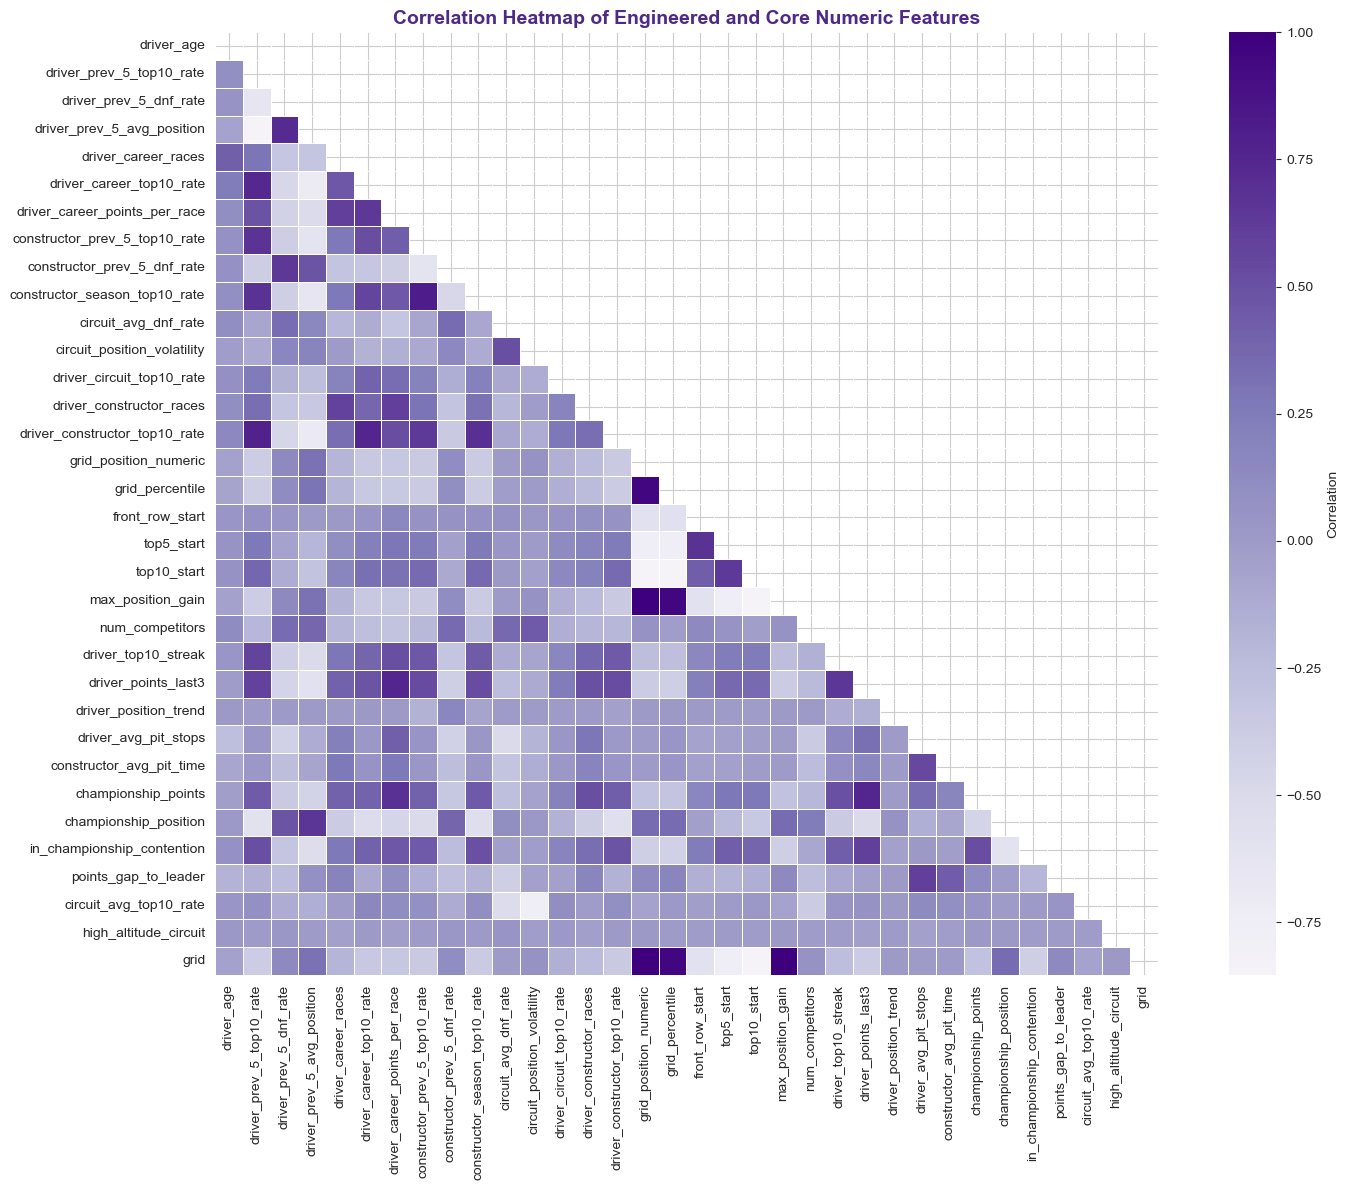

In [46]:
# Numeric feature set for correlation (exclude IDs + targets)
corr_features = [c for c in numeric_cols if c not in id_cols + target_cols]

# Core numeric variables to include for context
# IMPORTANT: positionOrder, points, milliseconds, and laps are POST-RACE outcomes
# They CANNOT be used as model features — they directly encode or correlate with the target.
# Only grid (starting position) is a legitimate pre-race feature.
core_numeric = ["grid"]
core_numeric = [c for c in core_numeric if c in df.columns]

# Combine engineered + core numeric features (unique, ordered)
corr_pick = list(dict.fromkeys(engineered_features + core_numeric))
corr_pick = [
    c for c in corr_pick
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c])
]

# Compute correlation matrix
corr_mat = df[corr_pick].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(16, 12))

mask = np.triu(np.ones_like(corr_mat, dtype=bool))

sns.heatmap(
    corr_mat,
    mask=mask,
    annot=False,
    cmap="Purples",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    ax=ax
)

ax.set_title(
    "Correlation Heatmap of Engineered and Core Numeric Features",
    fontsize=14,
    fontweight="bold",
    color=NU_COLORS["purple"]
)

plt.tight_layout()
plt.show()
plt.close(fig)

### Top Correlated Feature Pairs

In [47]:
# Extract strongest correlations (absolute value, upper triangle only)
corr_pairs = (
    corr_mat.abs()
    .where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
    .reset_index()
)

corr_pairs.columns = ["Feature 1", "Feature 2", "Absolute Correlation"]

# Display top 20 correlations
nu_style_table(
    corr_pairs.head(20),
    caption="Top 20 Absolute Correlations Among Engineered Features"
)

,Feature 1,Feature 2,Absolute Correlation
0,grid_position_numeric,grid,1.000000
1,max_position_gain,grid,1.000000
2,grid_position_numeric,max_position_gain,1.000000
3,grid_percentile,grid,0.953784
4,grid_position_numeric,grid_percentile,0.953784
5,grid_percentile,max_position_gain,0.953784
6,driver_prev_5_top10_rate,driver_prev_5_avg_position,0.853163
7,top10_start,grid,0.850827
8,grid_position_numeric,top10_start,0.850827
9,top10_start,max_position_gain,0.850827


# Feature Importance
This section identifies which variables contribute most to predicting a Top-10 finish. We use model-based feature importance to compare the impact of engineered features, qualifying signals, constructor strength, and championship context. This helps explain the model’s behavior and supports decision-oriented insights rather than treating the model as a black box.

## Model feature matrix

In [48]:
# Encoded categorical columns
encoded_cols = [c for c in df.columns if c.endswith("_encoded")]

# One-hot encoded season columns
season_ohe_cols = [c for c in df.columns if c.startswith("season_")]

# These columns are POST-RACE outcomes that directly reveal or correlate with the target.
# They must NEVER be included as model features.
leakage_cols = [
    "positionOrder",    # Directly defines target: positionOrder <= 10 = top10_finish
    "points",           # Awarded based on finishing position (only top-10 score points)
    "milliseconds",     # Total race time (only recorded for finishers)
    "laps",             # Laps completed (DNF drivers complete fewer — post-race info)
    "position",         # Same as positionOrder
    "rank",             # Finishing rank
    "fastestLap",       # Post-race stat
    "fastestLapTime",   # Post-race stat
    "fastestLapSpeed",  # Post-race stat
    "statusId",         # Encodes whether driver finished or DNF
    "num_pit_stops",    # Actual pit stops in THIS race (not available pre-race)
    "total_pit_time_ms",# Actual pit time in THIS race (not available pre-race)
    "avg_pit_time_ms",  # Actual pit time in THIS race (not available pre-race)
]

# Combine engineered + encoded features, then exclude leakage + targets
feature_cols = list(dict.fromkeys(corr_pick + encoded_cols + season_ohe_cols))

target_cols_full = ["top10_finish", "points_finish", "podium_finish", "dnf"]
feature_cols = [c for c in feature_cols if c not in target_cols_full + leakage_cols]

X = df[feature_cols].copy()
y = df["top10_finish"].astype(int)

print(f"Total features: {X.shape[1]}")
print(f"Total observations: {X.shape[0]}")
print(f"\nFeatures used ({len(feature_cols)}):")
for f in feature_cols:
    print(f"  - {f}")


Total features: 45
Total observations: 26759

Features used (45):
  - driver_age
  - driver_prev_5_top10_rate
  - driver_prev_5_dnf_rate
  - driver_prev_5_avg_position
  - driver_career_races
  - driver_career_top10_rate
  - driver_career_points_per_race
  - constructor_prev_5_top10_rate
  - constructor_prev_5_dnf_rate
  - constructor_season_top10_rate
  - circuit_avg_dnf_rate
  - circuit_position_volatility
  - driver_circuit_top10_rate
  - driver_constructor_races
  - driver_constructor_top10_rate
  - grid_position_numeric
  - grid_percentile
  - front_row_start
  - top5_start
  - top10_start
  - max_position_gain
  - num_competitors
  - driver_top10_streak
  - driver_points_last3
  - driver_position_trend
  - driver_avg_pit_stops
  - constructor_avg_pit_time
  - championship_points
  - championship_position
  - in_championship_contention
  - points_gap_to_leader
  - circuit_avg_top10_rate
  - high_altitude_circuit
  - grid
  - era_encoded
  - driverRef_encoded
  - constructorRef_enc

## LASSO Feature Importance (Linear Baseline)
LASSO is used as a linear baseline to identify a sparse set of features with the strongest direct association to Top-10 finishes.

In [49]:
# Scale features for LASSO
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# LASSO Logistic Regression
lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    max_iter=5000,
    random_state=42,
    class_weight="balanced"
)

lasso.fit(X_scaled, y)

# Extract coefficients
lasso_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso.coef_[0]
})

lasso_importance["Abs Coefficient"] = lasso_importance["Coefficient"].abs()
lasso_importance = lasso_importance.sort_values("Abs Coefficient", ascending=False)

# Keep non-zero features
lasso_nonzero = lasso_importance[lasso_importance["Coefficient"] != 0].reset_index(drop=True)

display(
    nu_style_table(
        lasso_nonzero.head(20),
        caption="Top Features Selected by LASSO (Logistic Regression)"
    )
)

print(f"Non-zero LASSO features: {lasso_nonzero.shape[0]}")

,Feature,Coefficient,Abs Coefficient
0,driver_prev_5_avg_position,-0.423071,0.423071
1,front_row_start,-0.318545,0.318545
2,constructor_season_top10_rate,0.263010,0.263010
3,grid_percentile,-0.229773,0.229773
4,constructor_prev_5_top10_rate,0.170903,0.170903
5,driver_prev_5_dnf_rate,0.159140,0.159140
6,championship_points,0.158990,0.158990
7,driver_points_last3,0.154450,0.154450
8,circuit_position_volatility,-0.135111,0.135111
9,circuit_avg_top10_rate,-0.122686,0.122686


Non-zero LASSO features: 44


## Tree-Based Feature Importance (Non-Linear)
Tree-based importance highlights non-linear effects and interactions that cannot be captured by linear models.

In [50]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X, y)

rf_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

nu_style_table(
    rf_importance.head(20),
    caption="Top Features by Random Forest Importance"
)

,Feature,Importance
9,constructor_season_top10_rate,0.074882
28,championship_position,0.067456
15,grid_position_numeric,0.063724
23,driver_points_last3,0.062275
14,driver_constructor_top10_rate,0.062050
20,max_position_gain,0.061995
33,grid,0.061517
3,driver_prev_5_avg_position,0.051694
1,driver_prev_5_top10_rate,0.038568
16,grid_percentile,0.038429


## Temporal Train / Validation / Test Split
In many machine learning projects, the dataset is split into training and testing sets before any preprocessing in order to prevent data leakage. In this project, feature engineering is performed before the split because the entire feature construction process is explicitly designed to be leakage-safe. All rolling and expanding features are calculated using shift(1) within grouped operations, which ensures that each observation only uses information from races that occurred prior to the race being predicted. As a result, generating features on the full dataset does not introduce future information into the model.

Performing feature engineering before splitting also preserves the continuity of rolling windows. If the data were split first, rolling statistics would reset at split boundaries and create artificial missing values, particularly for drivers and constructors at the beginning of each split period. Computing features on the full dataset avoids this issue while remaining methodologically correct.

A temporal split is used to reflect a realistic prediction setting. The model is trained on races that occurred before 2018, validated on races from 2018 through 2021, and tested on races from 2022 to 2024. This approach mirrors how the model would be used in practice, where predictions are made on future seasons using information from past seasons. A random split would be inappropriate in this context because it would allow the model to learn from future data when predicting earlier races, violating the natural time ordering of Formula One competition and leading to overly optimistic performance estimates (Bansal 2025; Jafri 2024).

In [51]:
# Temporal three-way split
TRAIN_END = 2018      # Train: < 2018
VAL_END = 2022        # Validation: 2018–2021 | Test: 2022+

train_idx = df["year"] < TRAIN_END
val_idx = (df["year"] >= TRAIN_END) & (df["year"] < VAL_END)
test_idx = df["year"] >= VAL_END

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val, y_val     = X.loc[val_idx],   y.loc[val_idx]
X_test, y_test   = X.loc[test_idx],  y.loc[test_idx]

# Create summary table
split_summary = pd.DataFrame({
    "Split": [
        f"Train (< {TRAIN_END})",
        f"Validation ({TRAIN_END}–{VAL_END-1})",
        f"Test (≥ {VAL_END})",
        "Total"
    ],
    "Rows": [
        len(X_train),
        len(X_val),
        len(X_test),
        len(X)
    ],
    "Top-10 Rate": [
        f"{y_train.mean():.3f}",
        f"{y_val.mean():.3f}",
        f"{y_test.mean():.3f}",
        f"{y.mean():.3f}"
    ]
})

nu_style_table(
    split_summary,
    caption="Temporal Train, Validation, and Test Split Summary"
)

,Split,Rows,Top-10 Rate
0,Train (< 2018),23780,0.413
1,Validation (2018–2021),1620,0.500
2,Test (≥ 2022),1359,0.500
3,Total,26759,0.423


## Baseline models
This section trains three baseline classifiers (Logistic Regression, Random Forest, and Gradient Boosting) using the temporal train/validation/test split.

In [52]:
# Scale features for Logistic Regression (fit on train only)
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Define baseline models
lr = LogisticRegression(
    max_iter=2000,
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
    max_depth=15,
    min_samples_leaf=10
)

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_leaf=20,
    random_state=42,
    subsample=0.8
)

# Fit models
lr.fit(X_train_scaled, y_train)   # Logistic Regression uses scaled features
rf.fit(X_train, y_train)          # Tree-based models use unscaled features
gb.fit(X_train, y_train)

# Display training status
train_status = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Input Features": ["Scaled (StandardScaler)", "Unscaled", "Unscaled"],
    "Training Rows": [len(X_train), len(X_train), len(X_train)]
})

display(
    nu_style_table(
        train_status,
        caption="Baseline Models Trained Successfully"
    )
);

,Model,Input Features,Training Rows
0,Logistic Regression,Scaled (StandardScaler),23780
1,Random Forest,Unscaled,23780
2,Gradient Boosting,Unscaled,23780


## Evaluation (ROC AUC + PR AUC)

In [53]:
# Validation set performance (used for model selection)
val_scores = [
    eval_model(lr, X_val_scaled, y_val, "Logistic Regression"),
    eval_model(rf, X_val, y_val, "Random Forest"),
    eval_model(gb, X_val, y_val, "Gradient Boosting")
]

val_df = pd.DataFrame(val_scores)

display(
    nu_style_table(
        val_df,
        caption="Validation Set Performance (2018–2021)"
    )
);

# Test set performance (holdout, final evaluation)
test_scores = [
    eval_model(lr, X_test_scaled, y_test, "Logistic Regression"),
    eval_model(rf, X_test, y_test, "Random Forest"),
    eval_model(gb, X_test, y_test, "Gradient Boosting")
]

test_df = pd.DataFrame(test_scores)

display(
    nu_style_table(
        test_df,
        caption="Test Set Performance (2022–2024, Holdout)"
    )
);

,Model,ROC AUC,PR AUC,F1 Score
0,Logistic Regression,0.8217,0.7935,0.7269
1,Random Forest,0.8401,0.8015,0.7808
2,Gradient Boosting,0.8274,0.8013,0.7553


,Model,ROC AUC,PR AUC,F1 Score
0,Logistic Regression,0.8568,0.8486,0.7748
1,Random Forest,0.8691,0.8538,0.8077
2,Gradient Boosting,0.8580,0.8334,0.7957


The baseline models show consistent and reasonable performance across both the validation and holdout test periods. On the validation set (2018–2021), the Random Forest model performs best overall, achieving the highest ROC AUC (0.8401) and F1 score (0.7808), followed by Gradient Boosting and Logistic Regression. This suggests that non-linear models are better able to capture interaction effects and complex relationships in the data compared to a linear baseline. On the holdout test set (2022–2024), all three models improve slightly, with Random Forest again achieving the strongest results, including a ROC AUC of 0.8691 and an F1 score of 0.8077. The similar ranking and stable performance across both periods indicate that the models generalize well to unseen seasons. These results support the use of tree-based methods as strong baselines for Formula One outcome prediction, while Logistic Regression provides a useful interpretable benchmark.

## Feature importance
This section examines feature importance using the Random Forest model to identify which variables contribute most to predicting top-10 finishes, capturing non-linear effects and interactions that are not reflected in linear models.

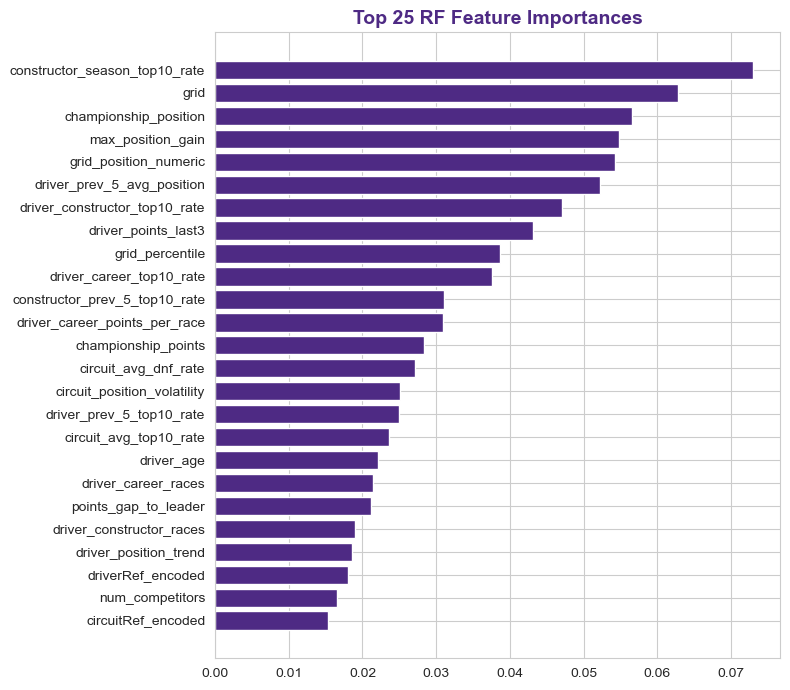

In [54]:
rf_imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
rf_imp_df = rf_imp.head(25).reset_index()
rf_imp_df.columns = ["feature", "importance"]
nu_style_table(rf_imp_df, caption="Top 25 Feature Importances (RandomForest)")

plt.figure(figsize=(8, 7))
plt.barh(rf_imp_df["feature"][::-1], rf_imp_df["importance"][::-1])
plt.title("Top 25 RF Feature Importances")
plt.tight_layout()
plt.show()


## Permutation importance
This section uses permutation importance on the test set to measure how much each feature truly contributes to predictive performance by observing the change in model accuracy when the feature’s values are randomly shuffled.

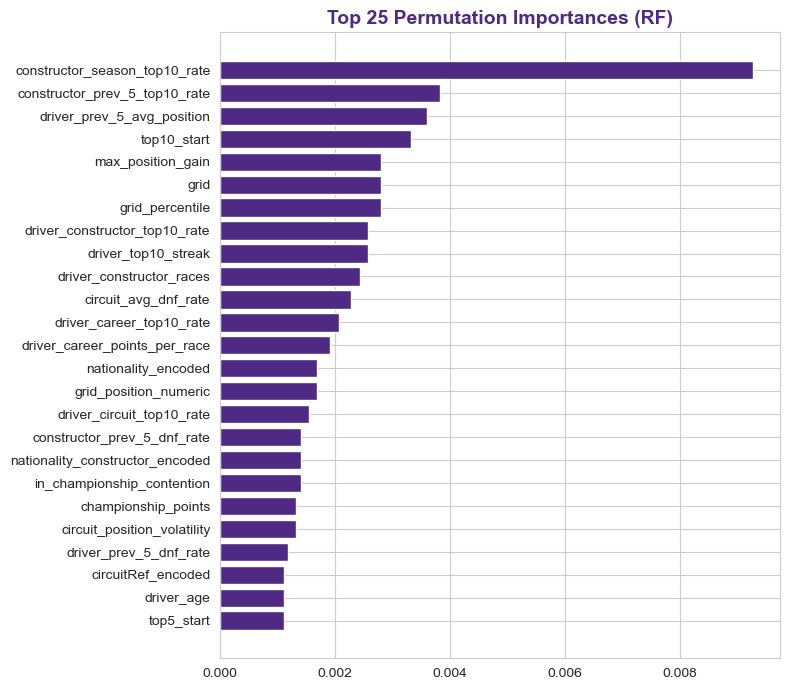

In [55]:
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)

perm_df = perm_imp.head(25).reset_index()
perm_df.columns = ["feature", "perm_importance"]
nu_style_table(perm_df, caption="Top 25 Permutation Importances (RF on Test)")

plt.figure(figsize=(8, 7))
plt.barh(perm_df["feature"][::-1], perm_df["perm_importance"][::-1])
plt.title("Top 25 Permutation Importances (RF)")
plt.tight_layout()
plt.show()

# Interactive Dashboard
This section provides an interactive notebook dashboard that lets the user filter the Formula One dataset and instantly update key KPIs and core charts. The dashboard is built using ipywidgets with Matplotlib to keep the visuals consistent with the rest of the notebook while still allowing interactive exploration.

In [56]:
# Base dashboard dataframe
df_dash = df.copy()
df_dash["year"] = pd.to_numeric(df_dash["year"], errors="coerce")

# Season stage label (same logic you used)
df_dash["season_stage_label"] = pd.cut(
    df_dash["round"],
    bins=[0, 7, 14, 21, 100],
    labels=["Early", "Mid", "Late", "End"]
).astype(str)

min_year = int(df_dash["year"].min())
max_year = int(df_dash["year"].max())

# Filters (widgets)
year_slider = widgets.IntRangeSlider(
    value=[min_year, max_year],
    min=min_year,
    max=max_year,
    step=1,
    description="Years",
    continuous_update=False,
    layout=widgets.Layout(width="70%")
)

era_opts = ["All"] + sorted(df_dash["era"].dropna().astype(str).unique().tolist())
era_dd = widgets.Dropdown(options=era_opts, value="All", description="Era")

constructor_opts = ["All"] + sorted(df_dash["constructor_name"].dropna().astype(str).unique().tolist())
constructor_dd = widgets.Dropdown(options=constructor_opts, value="All", description="Team")

driver_opts = ["All"] + sorted(df_dash["driver_name"].dropna().astype(str).unique().tolist())
driver_dd = widgets.Dropdown(options=driver_opts, value="All", description="Driver")

reset_btn = widgets.Button(description="Reset", button_style="warning")
out = widgets.Output()

def apply_filters(df_in):
    df_f = df_in.copy()

    y0, y1 = year_slider.value
    df_f = df_f[(df_f["year"] >= y0) & (df_f["year"] <= y1)]

    if era_dd.value != "All":
        df_f = df_f[df_f["era"].astype(str) == era_dd.value]

    if constructor_dd.value != "All":
        df_f = df_f[df_f["constructor_name"].astype(str) == constructor_dd.value]

    if driver_dd.value != "All":
        df_f = df_f[df_f["driver_name"].astype(str) == driver_dd.value]

    return df_f

# Full dashboard render (CARDS + ALL CHARTS)
def render_dashboard():
    with out:
        clear_output(wait=True)

        df_f = apply_filters(df_dash)

        if df_f.empty:
            display(HTML("<b>No data matches the selected filters.</b>"))
            return

        # KPI Summary Cards
        total_races = df_f["raceId"].nunique()
        total_drivers = df_f["driverId"].nunique()
        total_constructors = df_f["constructorId"].nunique()
        overall_top10_rate = df_f["top10_finish"].mean() * 100
        overall_dnf_rate = df_f["dnf"].mean() * 100
        year_range = f"{int(df_f['year'].min())}–{int(df_f['year'].max())}"

        kpi_html = f"""
        <div style="display:flex; gap:15px; flex-wrap:wrap; margin-bottom:20px;">
          <div style="flex:1; min-width:140px; background:#4E2A84; color:white; padding:15px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.8;">Period</div>
            <div style="font-size:22px; font-weight:bold;">{year_range}</div>
          </div>
          <div style="flex:1; min-width:140px; background:#4E2A84; color:white; padding:15px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.8;">Total Races</div>
            <div style="font-size:22px; font-weight:bold;">{total_races:,}</div>
          </div>
          <div style="flex:1; min-width:140px; background:#4E2A84; color:white; padding:15px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.8;">Unique Drivers</div>
            <div style="font-size:22px; font-weight:bold;">{total_drivers:,}</div>
          </div>
          <div style="flex:1; min-width:140px; background:#4E2A84; color:white; padding:15px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.8;">Constructors</div>
            <div style="font-size:22px; font-weight:bold;">{total_constructors:,}</div>
          </div>
          <div style="flex:1; min-width:140px; background:#836EAA; color:white; padding:15px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.8;">Top-10 Rate</div>
            <div style="font-size:22px; font-weight:bold;">{overall_top10_rate:.1f}%</div>
          </div>
          <div style="flex:1; min-width:140px; background:#836EAA; color:white; padding:15px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.8;">DNF Rate</div>
            <div style="font-size:22px; font-weight:bold;">{overall_dnf_rate:.1f}%</div>
          </div>
        </div>
        """
        display(HTML(kpi_html))

        # Chart 1: Top-10 Rate & DNF Rate by Year
        yearly = df_f.groupby("year").agg(
            top10_rate=("top10_finish", "mean"),
            dnf_rate=("dnf", "mean"),
            races=("raceId", "nunique")
        ).reset_index()
        yearly["top10_rate"] *= 100
        yearly["dnf_rate"] *= 100

        fig1 = make_subplots(specs=[[{"secondary_y": True}]])
        fig1.add_trace(
            go.Scatter(
                x=yearly["year"], y=yearly["top10_rate"],
                name="Top-10 Rate %",
                line=dict(color="#4E2A84", width=2.5),
                mode="lines"
            ),
            secondary_y=False
        )
        fig1.add_trace(
            go.Scatter(
                x=yearly["year"], y=yearly["dnf_rate"],
                name="DNF Rate %",
                line=dict(color="#DC143C", width=2, dash="dot"),
                mode="lines"
            ),
            secondary_y=True
        )
        fig1.update_layout(
            title="Top-10 Finish Rate & DNF Rate by Season",
            xaxis_title="Year",
            template="plotly_white",
            height=400,
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )
        fig1.update_yaxes(title_text="Top-10 Rate (%)", secondary_y=False, color="#4E2A84")
        fig1.update_yaxes(title_text="DNF Rate (%)", secondary_y=True, color="#DC143C")
        fig1.show()

        # Chart 2: Top-10 Rate by Grid Position
        grid_rates = df_f[df_f["grid_position_numeric"].between(1, 20)].groupby(
            "grid_position_numeric"
        )["top10_finish"].mean().reset_index()
        grid_rates["top10_finish"] *= 100

        fig2 = px.bar(
            grid_rates,
            x="grid_position_numeric",
            y="top10_finish",
            title="Top-10 Finish Rate by Starting Grid Position",
            labels={"grid_position_numeric": "Grid Position", "top10_finish": "Top-10 Rate (%)"},
            color="top10_finish",
            color_continuous_scale=["#D8D6D6", "#836EAA", "#4E2A84"]
        )
        fig2.update_layout(template="plotly_white", height=400, showlegend=False)
        fig2.show()

        # Chart 3: Top 15 Drivers by Top-10 Rate (min 50 races)
        drv = df_f.groupby("driver_name").agg(
            top10_rate=("top10_finish", "mean"),
            races=("raceId", "count"),
            avg_grid=("grid_position_numeric", "mean")
        ).reset_index()

        drv = drv[drv["races"] >= 50].sort_values("top10_rate", ascending=True).tail(15)
        drv["top10_rate"] *= 100

        fig3 = px.bar(
            drv,
            x="top10_rate",
            y="driver_name",
            orientation="h",
            title="Top 15 Drivers by Top-10 Rate (min 50 races)",
            labels={"top10_rate": "Top-10 Rate (%)", "driver_name": ""},
            color="top10_rate",
            color_continuous_scale=["#836EAA", "#4E2A84"],
            hover_data={"races": True, "avg_grid": ":.1f"}
        )
        fig3.update_layout(template="plotly_white", height=500, showlegend=False)
        fig3.show()

        # Chart 4: Top 15 Constructors by Top-10 Rate (min 50 entries)
        con = df_f.groupby("constructor_name").agg(
            top10_rate=("top10_finish", "mean"),
            entries=("raceId", "count"),
            dnf_rate=("dnf", "mean")
        ).reset_index()

        con = con[con["entries"] >= 50].sort_values("top10_rate", ascending=True).tail(15)
        con["top10_rate"] *= 100
        con["dnf_rate"] *= 100

        fig4 = px.bar(
            con,
            x="top10_rate",
            y="constructor_name",
            orientation="h",
            title="Top 15 Constructors by Top-10 Rate (min 50 entries)",
            labels={"top10_rate": "Top-10 Rate (%)", "constructor_name": ""},
            color="top10_rate",
            color_continuous_scale=["#836EAA", "#4E2A84"],
            hover_data={"entries": True, "dnf_rate": ":.1f"}
        )
        fig4.update_layout(template="plotly_white", height=500, showlegend=False)
        fig4.show()

        # Chart 5: Era Comparison (grouped bar)
        era_stats = df_f.groupby("era").agg(
            top10_rate=("top10_finish", "mean"),
            dnf_rate=("dnf", "mean"),
            avg_competitors=("num_competitors", "mean"),
            races=("raceId", "nunique")
        ).reset_index()

        era_stats["top10_rate"] *= 100
        era_stats["dnf_rate"] *= 100

        fig5 = go.Figure()
        fig5.add_trace(go.Bar(x=era_stats["era"], y=era_stats["top10_rate"],
                              name="Top-10 Rate %", marker_color="#4E2A84"))
        fig5.add_trace(go.Bar(x=era_stats["era"], y=era_stats["dnf_rate"],
                              name="DNF Rate %", marker_color="#DC143C"))
        fig5.update_layout(
            title="Performance Metrics by F1 Regulation Era",
            barmode="group",
            template="plotly_white",
            height=400,
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )
        fig5.show()

        # Chart 6: Feature Importance (if RF trained)
        if "rf_imp" in globals():
            imp_df = rf_imp.head(20).reset_index()
            imp_df.columns = ["feature", "importance"]
            imp_df = imp_df.sort_values("importance", ascending=True)

            fig6 = px.bar(
                imp_df,
                x="importance",
                y="feature",
                orientation="h",
                title="Top 20 Random Forest Feature Importances",
                labels={"importance": "Importance", "feature": ""},
                color="importance",
                color_continuous_scale=["#D8D6D6", "#836EAA", "#4E2A84"]
            )
            fig6.update_layout(template="plotly_white", height=550, showlegend=False)
            fig6.show()

        # Chart 7: Circuit Explorer (Top 20 circuits, interactive legend filter)
        if "circuit_name" in df_f.columns:
            top_circuits = df_f.groupby("circuit_name")["raceId"].nunique().nlargest(20).index.tolist()
            circuit_data = df_f[df_f["circuit_name"].isin(top_circuits)]

            circuit_yearly = circuit_data.groupby(["circuit_name", "year"]).agg(
                top10_rate=("top10_finish", "mean"),
                dnf_rate=("dnf", "mean")
            ).reset_index()

            circuit_yearly["top10_rate"] *= 100

            fig7 = px.line(
                circuit_yearly,
                x="year",
                y="top10_rate",
                color="circuit_name",
                title="Top-10 Rate Over Time by Circuit (Top 20 Circuits — click legend to filter)",
                labels={"top10_rate": "Top-10 Rate (%)", "year": "Year", "circuit_name": "Circuit"},
                template="plotly_white"
            )
            fig7.update_layout(
                height=500,
                legend=dict(font=dict(size=9), itemclick="toggle", itemdoubleclick="toggleothers")
            )
            fig7.show()

# Wire up events

year_slider.observe(on_change, names="value")
era_dd.observe(on_change, names="value")
constructor_dd.observe(on_change, names="value")
driver_dd.observe(on_change, names="value")
reset_btn.on_click(on_reset)

display(widgets.HBox([year_slider, reset_btn]))
display(widgets.HBox([era_dd, constructor_dd, driver_dd]))
display(out)

render_dashboard()

Output()

# References:  

Bansal, Aayam. 2025. Advanced Machine Learning Approaches for Formula 1 Race Performance Prediction: A Comprehensive Analysis of Championship Point Forecasting. https://doi.org/10.13140/RG.2.2.20910.01607.

Gu, Yin, Qi Liu, Kai Zhang, Zhenya Huang, Runze Wu, and Jianrong Tao. 2021. "NeuralAC: Learning Cooperation and Competition Effects for Match Outcome Prediction." Proceedings of the AAAI Conference on Artificial Intelligence 35 (5): 4072–80. https://doi.org/10.1609/aaai.v35i5.16528.

Jafri, Ali. 2024. Predicting Formula 1 Race Outcomes: A Machine Learning Approach. Capstone project. https://aliabdullahjafri.com/static/media/Ali_Jafri_CapstoneProject1_Fall2024.c7244022875d46bec5d9.pdf.

Patil, Ankur, Nishtha Jain, Rahul Agrahari, Murhaf Hossari, Fabrizio Orlandi, and Soumyabrata Dev. 2023. "A Data-Driven Analysis of Formula 1 Car Races Outcome." Communications in Computer and Information Science, 134–46. https://doi.org/10.1007/978-3-031-26438-2_11.

Rockerbie, Duane W., and Stephen T. Easton. 2022. "Race to the Podium: Separating and Conjoining the Car and Driver in F1 Racing." Applied Economics 54 (54): 6272–85. https://doi.org/10.1080/00036846.2022.2083068.

Urdhwareshe, A. 2025. "The Use of Machine Learning in Predicting Formula 1 Race Outcomes." Preprints. https://doi.org/10.20944/preprints202504.1471.v1.

van Kesteren, Erik-Jan, and Tom Bergkamp. 2023. "Bayesian Analysis of Formula One Race Results: Disentangling Driver Skill and Constructor Advantage." Journal of Quantitative Analysis in Sports 19 (4): 273–93. https://doi.org/10.1515/jqas-2022-0021.

Vopani. 2025. "Formula 1 World Championship (1950–2024)." Kaggle. https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020.

Zheng, Xi. 2022. "NBA Winner Prediction: A Hybrid Framework Incorporating Internal and External Factors." In 2022 4th International Conference on Big Data Engineering, 71–80. https://doi.org/10.1145/3538950.3538960.
